In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import fiona
#import geoplot as gplt
#import geoplot.crs as gcrs
import geopandas as gpd
import seaborn as sns

In [2]:
#Import dataset
fullwi= pd.read_csv("all_animals_crashes_2017_2022.csv")

C:\Users\Aaron\AppData\Local\Temp\ipykernel_22796\3301258391.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  fullwi= pd.read_csv("all_animals_crashes_2017_2022.csv")


In [3]:
#Combb=ine streets and highways into single 'Road' column
fullwi["Highway"] = fullwi["ONHWYSYS"] + fullwi["ONHWY"]
fullwi["Street"] = fullwi["ONSTR"] + " - " + fullwi["countyname"]
fullwi["Road"] = fullwi["Highway"].combine_first(fullwi['Street'])

In [4]:
#Add columns for times and date
fullwi['date'] = pd.to_datetime(fullwi['CRSHDATE'])
fullwi['nummonth'] = fullwi['date'].dt.month
fullwi["dow"] = fullwi["date"].dt.dayofweek
fullwi['hour'] = (fullwi['CRSHTIME']//100) #rounds time up to whole number

In [5]:
# Dataset with only entries that have GPS coordinates
# Used for mapping, 'fullwi' used for other anaylis
wicord= fullwi[["CRSHDATE","CRSHTIME", "LATDECDG", "LONDECDG", "ANMLTY01","ANMLTY07", "countyname", "year", "Road"]]
#wicord = wicord.drop(wicord[wicord.LATDECDG == "NA"].index)'
wicord = wicord.dropna(subset=["LATDECDG"])
#there was a random single point that was noticably outside of wisconsin. this drops that single point
wicord = wicord.drop(wicord[(wicord['LATDECDG'] < 44.25) & (wicord['LONDECDG'] < -92.25)].index)

In [7]:
#datasets for GIS
#Only needed to be ran once
'''
wicord.ANMLTY01.unique()
GISdeer = wicord.drop(wicord[wicord.ANMLTY01 !="Deer"].index)
GISdeer.to_csv("GIS/Datasets/Deer.csv")
GISother = wicord.drop(wicord[wicord.ANMLTY01 !="Other Non Domesticated"].index)
GISother.to_csv("GIS/Datasets/Other.csv")
GIScoyote = wicord.drop(wicord[wicord.ANMLTY01 !="Coyote"].index)
GIScoyote.to_csv("GIS/Datasets/Coyote.csv")
GISraccoon = wicord.drop(wicord[wicord.ANMLTY01 !="Raccoon(s)"].index)
GISraccoon.to_csv("GIS/Datasets/Raccoon.csv")
GISturkey = wicord.drop(wicord[wicord.ANMLTY01 !="Turkey"].index)
GISturkey.to_csv("GIS/Datasets/Turkey.csv")
GISbear = wicord.drop(wicord[wicord.ANMLTY01 !="Bear"].index)
GISbear.to_csv("GIS/Datasets/Bear.csv")
GISopossum = wicord.drop(wicord[wicord.ANMLTY01 !="Opossum"].index)
GISopossum.to_csv("GIS/Datasets/Opossum.csv")
'''
wicord.to_csv("GIS/Datasets/GIS17-22.csv")

In [6]:
# seperate datasets with no GPS for those with and without deer
nodeer = wicord.drop(wicord[wicord.ANMLTY01 == "Deer"].index)
justdeer = wicord.drop(wicord[wicord.ANMLTY01 !="Deer"].index)

In [7]:
# equivalant for Dane County
danecord = wicord.drop(wicord[wicord.countyname != "Dane"].index)
nodeerdane = nodeer.drop(nodeer[nodeer.countyname != "Dane"].index)
deerdane = danecord.drop(danecord[danecord.ANMLTY01 != "Deer"].index)

In [8]:
# Loading Shape Files for maps
WIR = gpd.read_file("Assets/Maps/WiRoads_NoLocal/Trans_RoadSegment_NoLocal.shp")
WiRoads = WIR.to_crs('EPSG:4269') #wisconsin roads
BWI = gpd.read_file("Assets/Maps/Wisconsin_State_Boundary_24K/Wisconsin_State_Boundary_24K.shp")
BareWi = BWI.to_crs('EPSG:4269') #wisconsin no county borders
DANE = gpd.read_file("Assets/Maps/DaneCo/DaneCoBoundary.shp")
Dane_wgs84 = DANE.to_crs('EPSG:4269') #blank dane
DROADS = gpd.read_file("Assets/Maps/DaneCoRoads_NoLocal/Dane_Roads_2012_NoLocal.shp")
DaneRoads = DROADS.to_crs('EPSG:4269') #dane county roads

ti43 = gpd.read_file("Assets/Maps/i43/i43.shp")
i43 = ti43.to_crs('EPSG:4269') # Interstate i43
ti94 = gpd.read_file("Assets/Maps/I94/I94_merge1.shp")
i94 = ti94.to_crs('EPSG:4269') # Interstate 94
tsth29 = gpd.read_file("Assets/Maps/sth29/sth29.shp")
sth29 = tsth29.to_crs('EPSG:4269') # State Highway 29

In [9]:
#specific road datasets
justi43 = wicord.drop(wicord[wicord.Road != "Interstate043"].index)
justi94 = wicord.drop(wicord[wicord.Road != "Interstate094"].index)
juststh29 = wicord.drop(wicord[wicord.Road != "State Highway029"].index)

In [10]:
i9094 = wicord.drop(wicord[(wicord['Road'] != "Interstate094") & (wicord['Road'] != "Interstate090")].index)

In [11]:
# color dictionary for different species
color_dict = dict({'Raccoon(s)':'tab:green',
                  'Opossum':'yellow',
                  'Coyote': 'tab:orange',
                  'Turkey': 'tab:red',
                  'Bear': 'tab:purple',
                  'Other Non Domesticated':'tab:blue',
                  'Deer':'deeppink'})

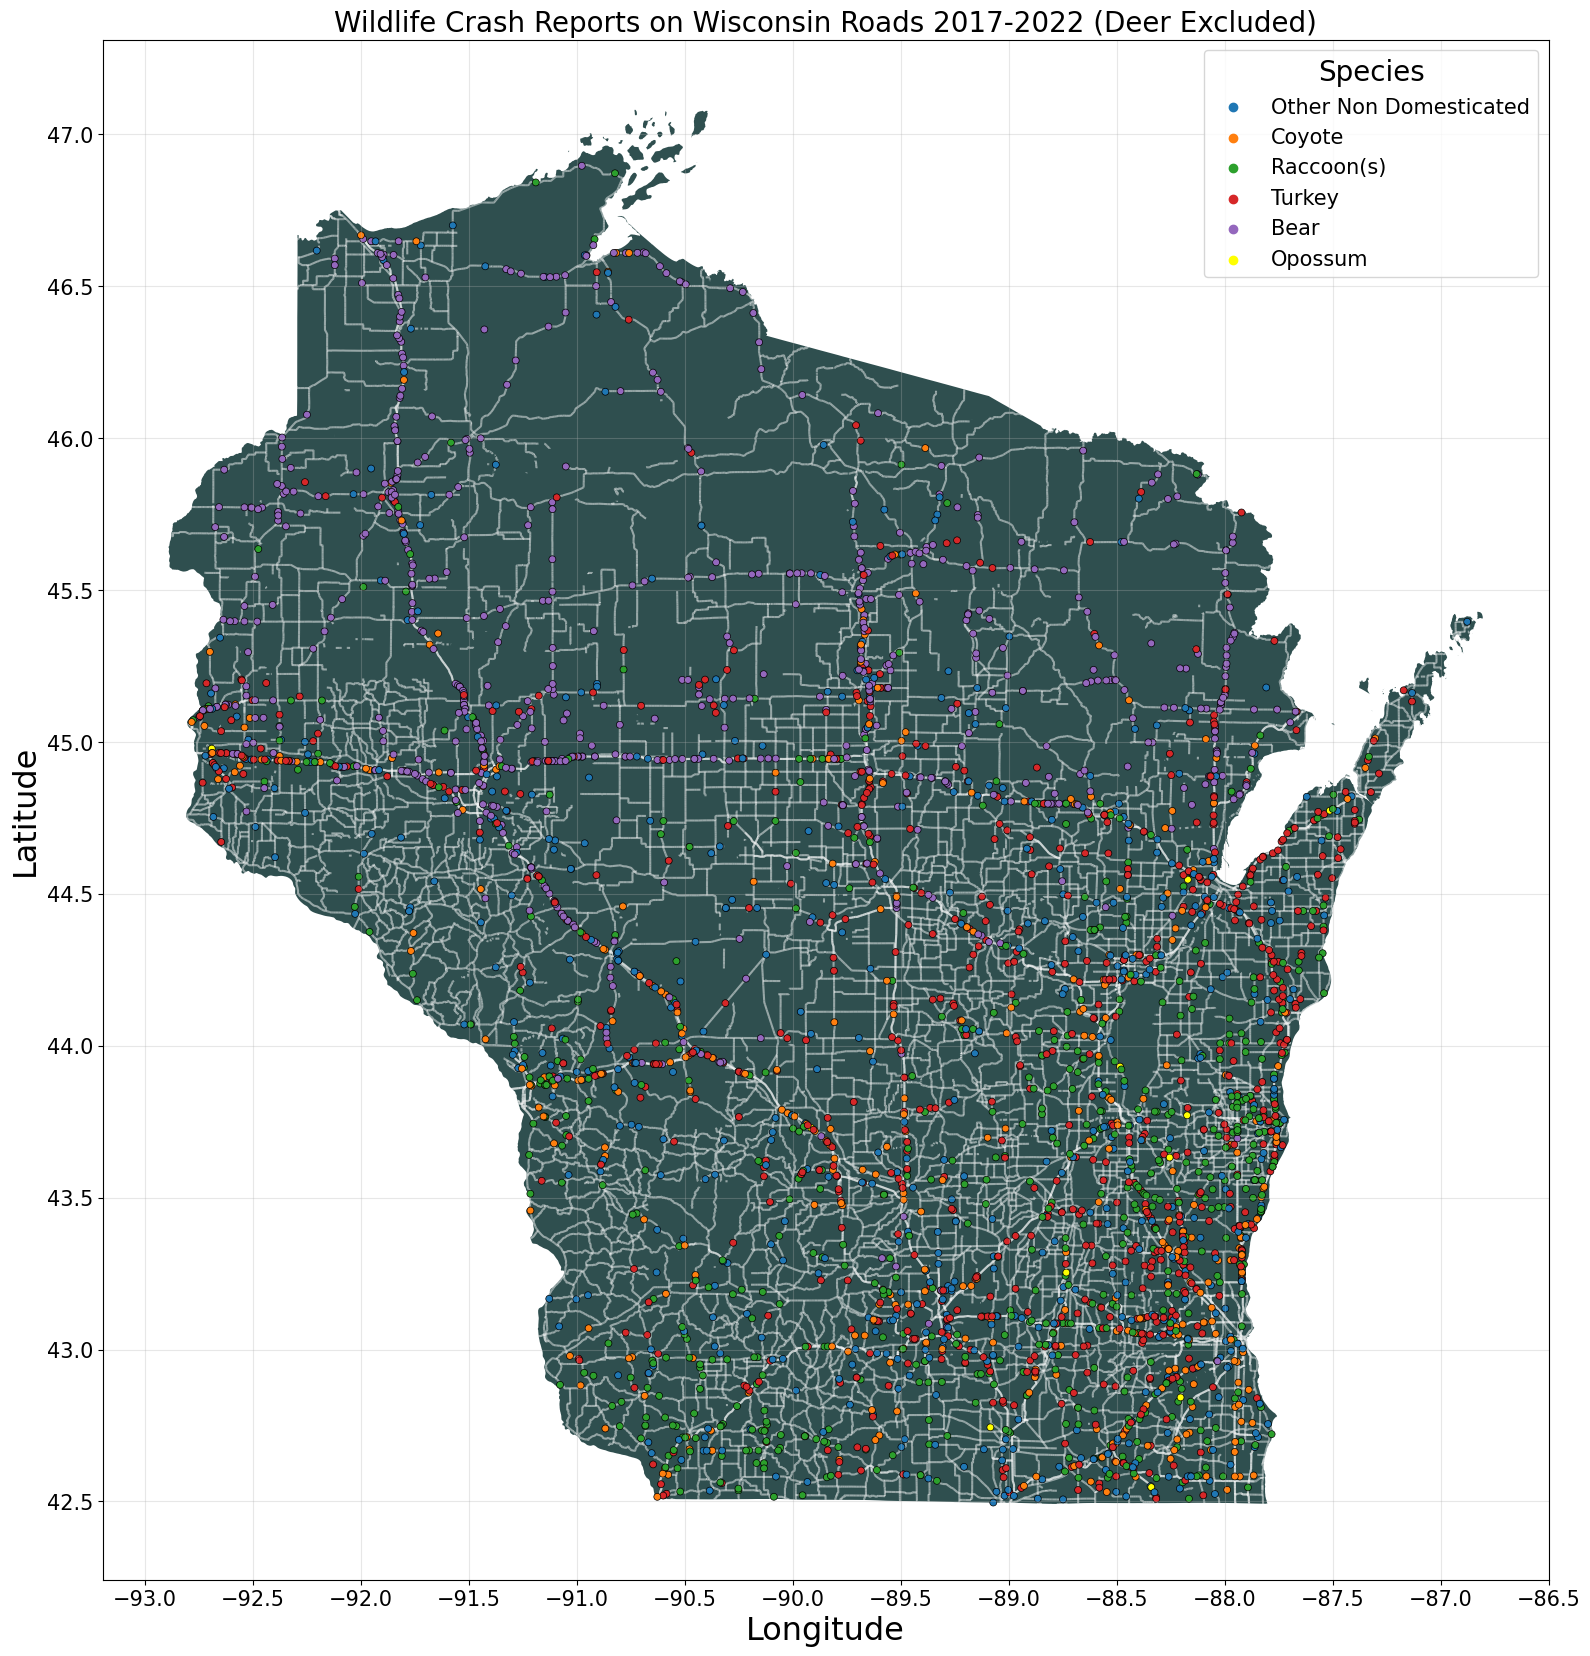

In [12]:
fig, ax = plt.subplots(figsize=(20,20)) #set size
BareWi.plot(ax=ax, color="darkslategray") #wisconsin background
WiRoads.plot(ax=ax, color="white", zorder=1, alpha=0.5) #map of the roads, zorder sets it to the back
sns.scatterplot(ax = ax,
                   data = nodeer,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = .5,
                   edgecolor = "black",
                   palette = color_dict,
                   hue = "ANMLTY01",   
                   s = 25,
                   alpha = 1)
#Set titles, ticks, and labels
ax.set_title("Wildlife Crash Reports on Wisconsin Roads 2017-2022 (Deer Excluded)", fontsize=20)
ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-93, -86, .5), fontsize=15)
plt.yticks(np.arange(42.5, 47.5, .5), fontsize=15)

plt.legend(title="Species", title_fontsize=20, fontsize=15)
#plt.savefig("Figures/Scatter Plot Maps/Wildlife Crash Reports 2017-2022 Wisconsin Roads (Deer Excluded).jpg", 
 #           dpi=300,bbox_inches='tight')

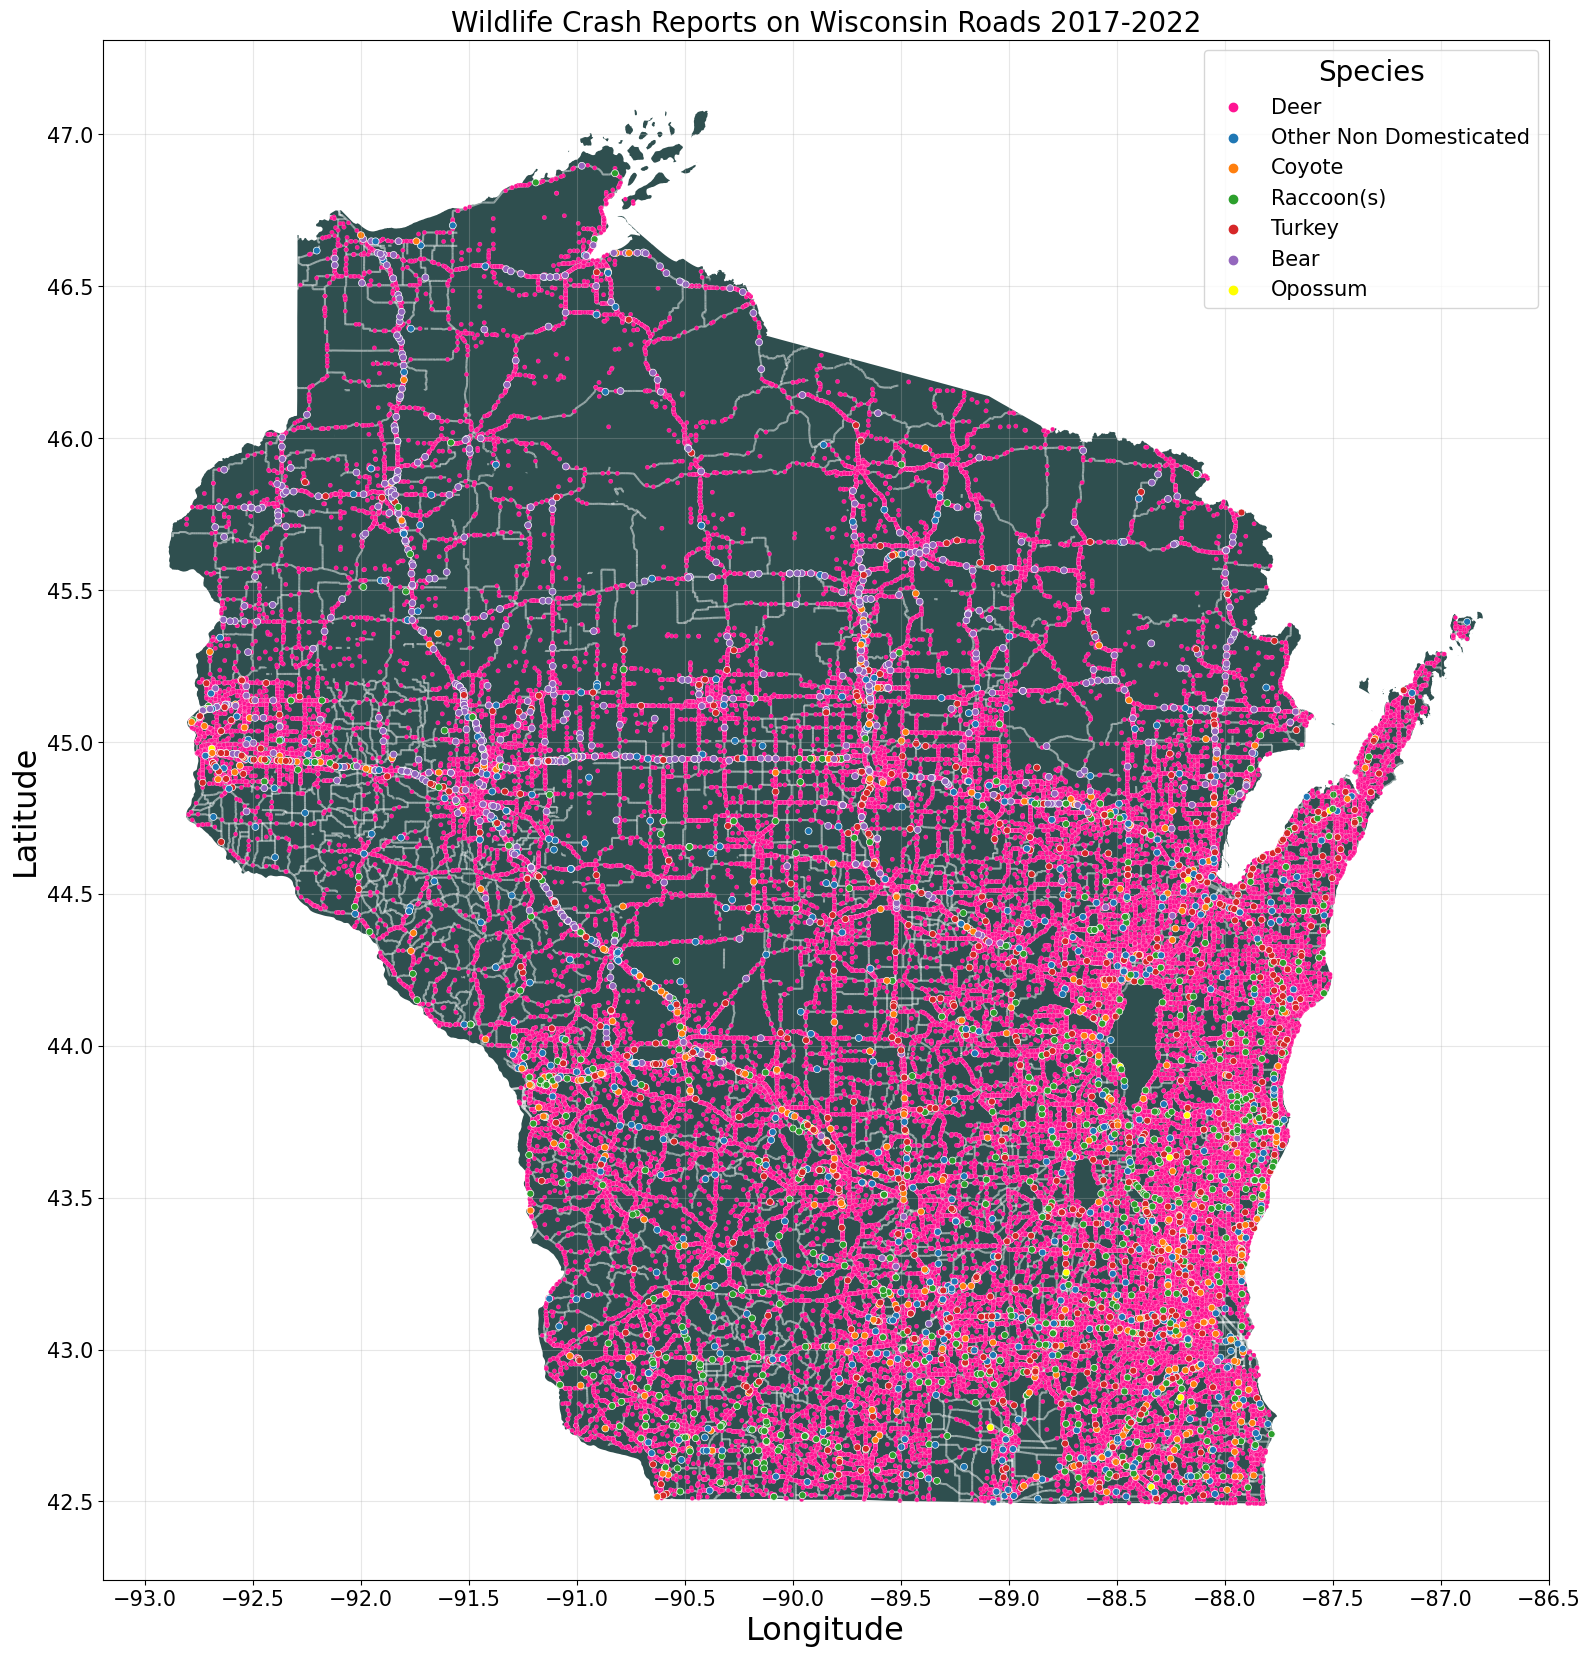

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
BareWi.plot(ax=ax, color="darkslategray")
WiRoads.plot(ax=ax, color="white", zorder=1, alpha=0.5)

sns.scatterplot(ax = ax, #have to plot it seperately since otherwise deer cover everything else up
                   data = justdeer,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = .1,
                   palette = color_dict,   
                   hue = "ANMLTY01",
                   s = 10,
                   alpha = 1)

sns.scatterplot(ax = ax,
                   data = nodeer,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = .5,
                   edgecolor = "white",
                   palette = color_dict,
                   hue = "ANMLTY01",   
                   s = 25,
                   alpha = 1)

ax.set_title("Wildlife Crash Reports on Wisconsin Roads 2017-2022", fontsize=20)
ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-93, -86, .5), fontsize=15)
plt.yticks(np.arange(42.5, 47.5, .5), fontsize=15)

plt.legend(title="Species", title_fontsize=20, fontsize=15)
#plt.savefig("Figures/Scatter Plot Maps/Wildlife Crash Reports 2017-2021 Wisconsin Roads with deer.jpg",
 #           dpi=300,bbox_inches='tight')

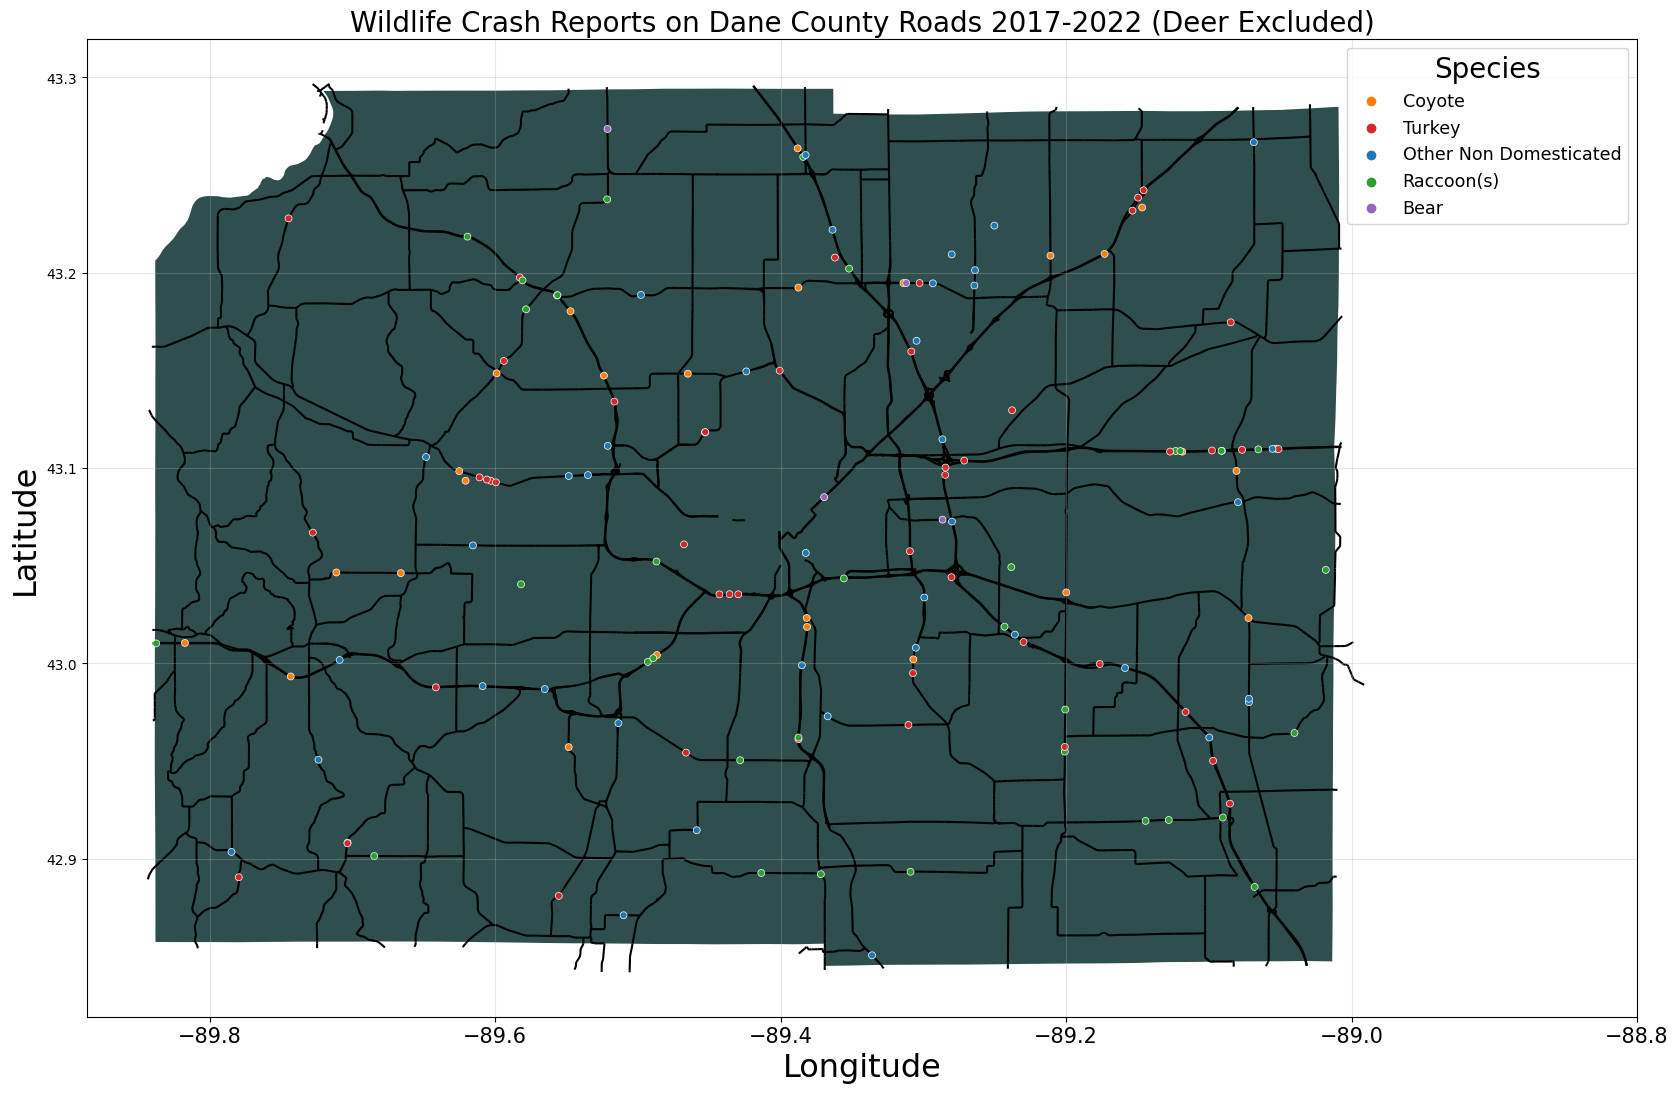

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
Dane_wgs84.plot(ax=ax, color="darkslategray")
DaneRoads.plot(ax=ax, alpha=1, color="black", zorder=1)

sns.scatterplot(ax = ax,
                   data = nodeerdane,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = .5,
                   palette = color_dict,
                   hue = "ANMLTY01",   
                   s = 25,
                   alpha = 1)

ax.set_title("Wildlife Crash Reports on Dane County Roads 2017-2022 (Deer Excluded)", fontsize=20)
ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-89.8, -88.7, .2), fontsize=15)

plt.legend(title="Species", title_fontsize=20, fontsize=12.6, loc = "upper right")
#plt.savefig("Figures/Scatter Plot Maps/Wildlife Crash Reports on Dane County Roads no deer 2017-2022.jpg",
 #            dpi=300,bbox_inches='tight')

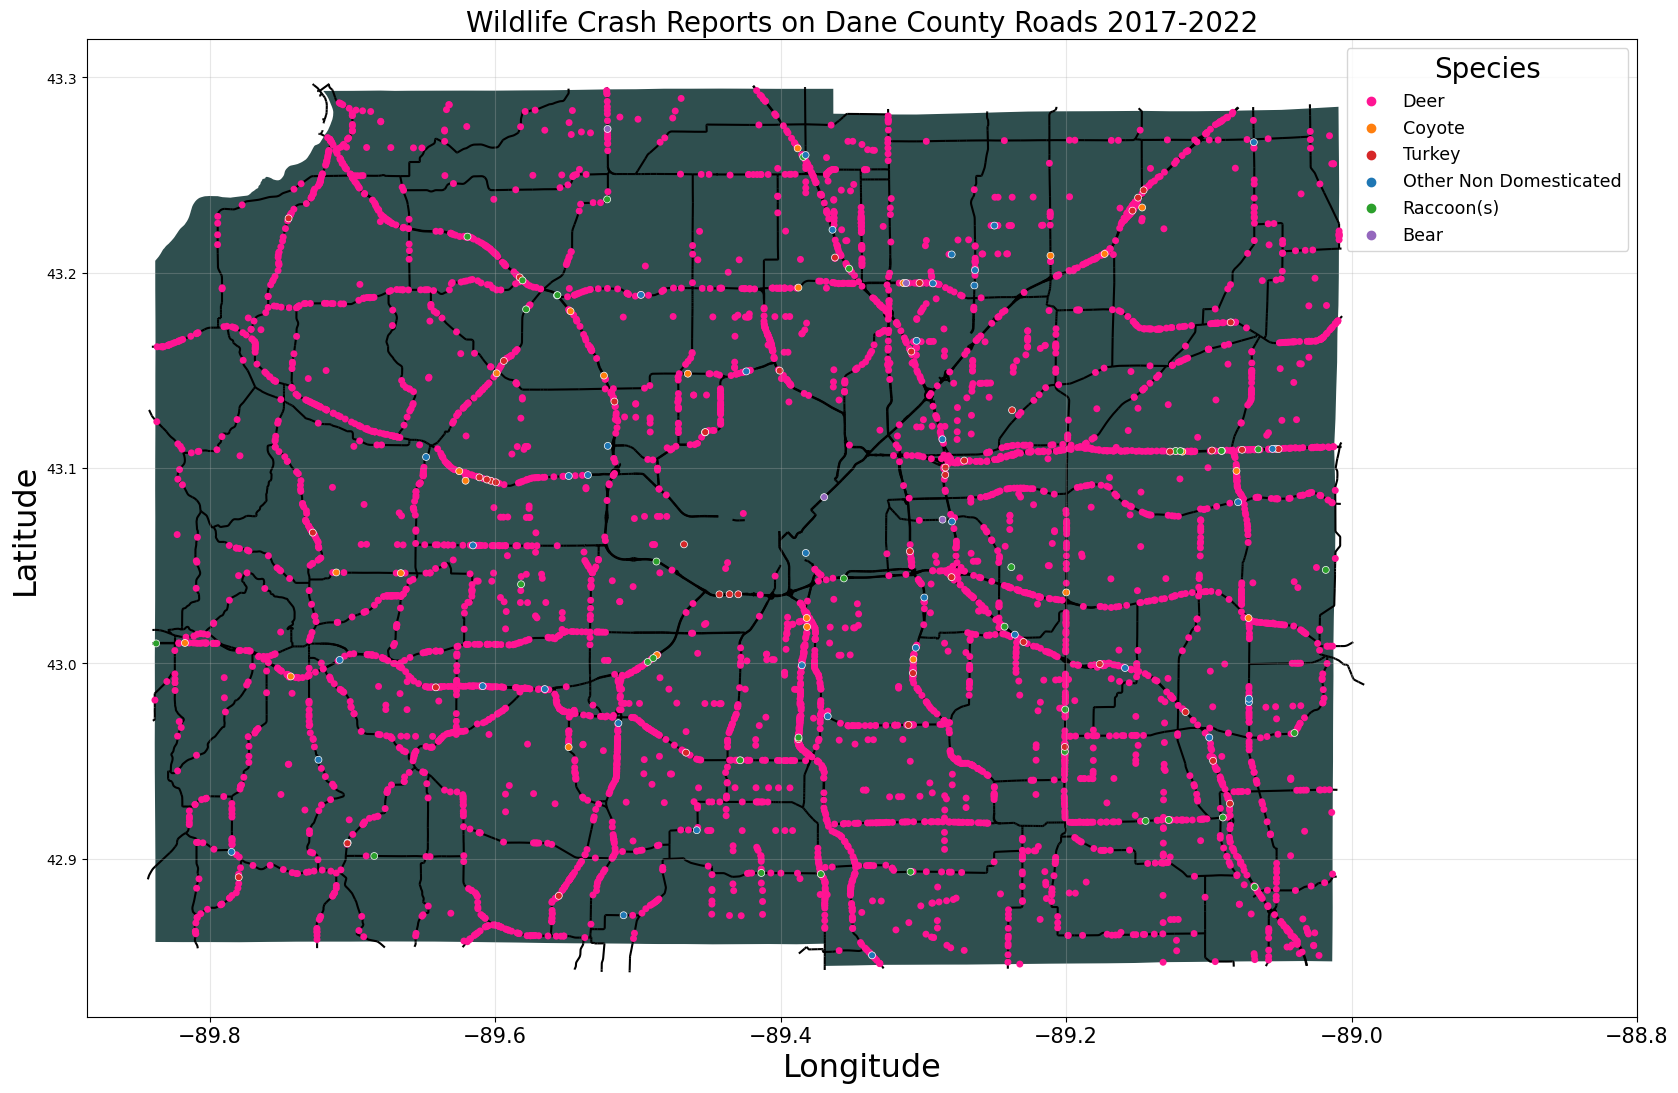

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
Dane_wgs84.plot(ax=ax, color="darkslategray")
DaneRoads.plot(ax=ax, alpha=1, color="black", zorder=1)

sns.scatterplot(ax = ax,
                   data = deerdane,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = 0,
                   palette = color_dict,
                   hue = "ANMLTY01",   
                   s = 25,
                   alpha = 1)

sns.scatterplot(ax = ax,
                   data = nodeerdane,
                   x = "LONDECDG",
                   y = "LATDECDG",
                   linewidth = .5,
                   palette = color_dict,
                   hue = "ANMLTY01",   
                   s = 25,
                   alpha = 1)

ax.set_title("Wildlife Crash Reports on Dane County Roads 2017-2022", fontsize=20)
ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-89.8, -88.7, .2), fontsize=15)

plt.legend(title="Species", title_fontsize=20, fontsize=12.6, loc = "upper right")
#plt.savefig("Figures/Scatter Plot Maps/Wildlife Crash Reports on Dane County Roads with deer 2017-2022.jpg",
 #           dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'Wildlife Crash Reports in Wisconsin Heatmap 2017-2022 (Deer excluded)')

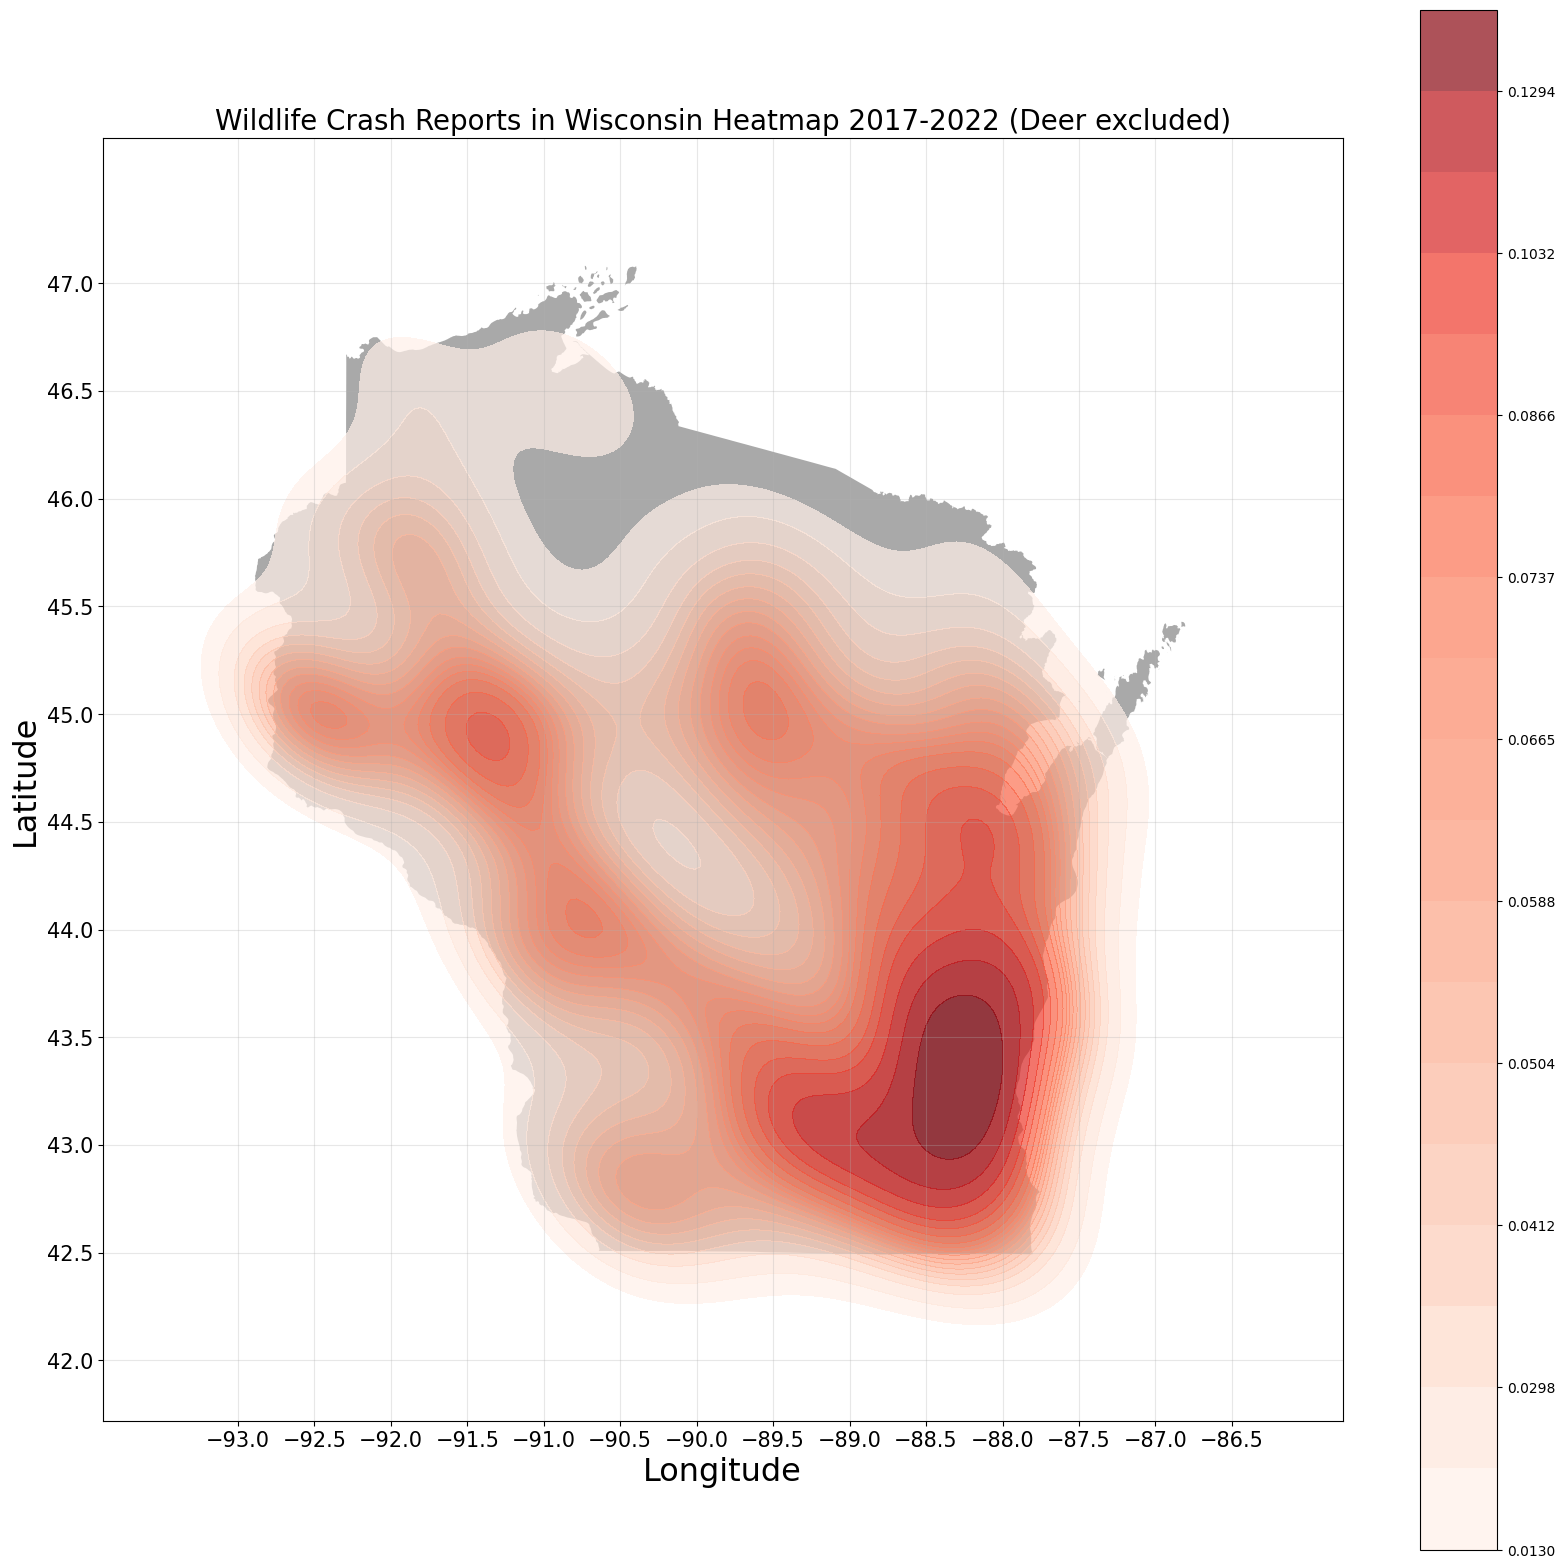

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
BareWi.plot(ax=ax, color="darkgray")

p = sns.kdeplot(ax = ax,
                data = nodeer,
                x = "LONDECDG",
                y = "LATDECDG",
                #linewidth = .5,
                fill=True,
                cmap='Reds', #CMRmap
                levels=20,
                cbar=True,
                #legend=True,
                alpha = .7)


ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-93, -86, .5), fontsize=15)
plt.yticks(np.arange(42, 47.1, .5), fontsize=15)
ax.set_title("Wildlife Crash Reports in Wisconsin Heatmap 2017-2022 (Deer excluded)", fontsize=20)
#plt.savefig("Figures/Heat Plot Maps/Wildlife Crash Reports 2017-2022 Wisconsin Heatmap no Deer.jpg")

Text(0.5, 1.0, 'Wildlife Crash Reports in Wisconsin Heatmap 2017-2022')

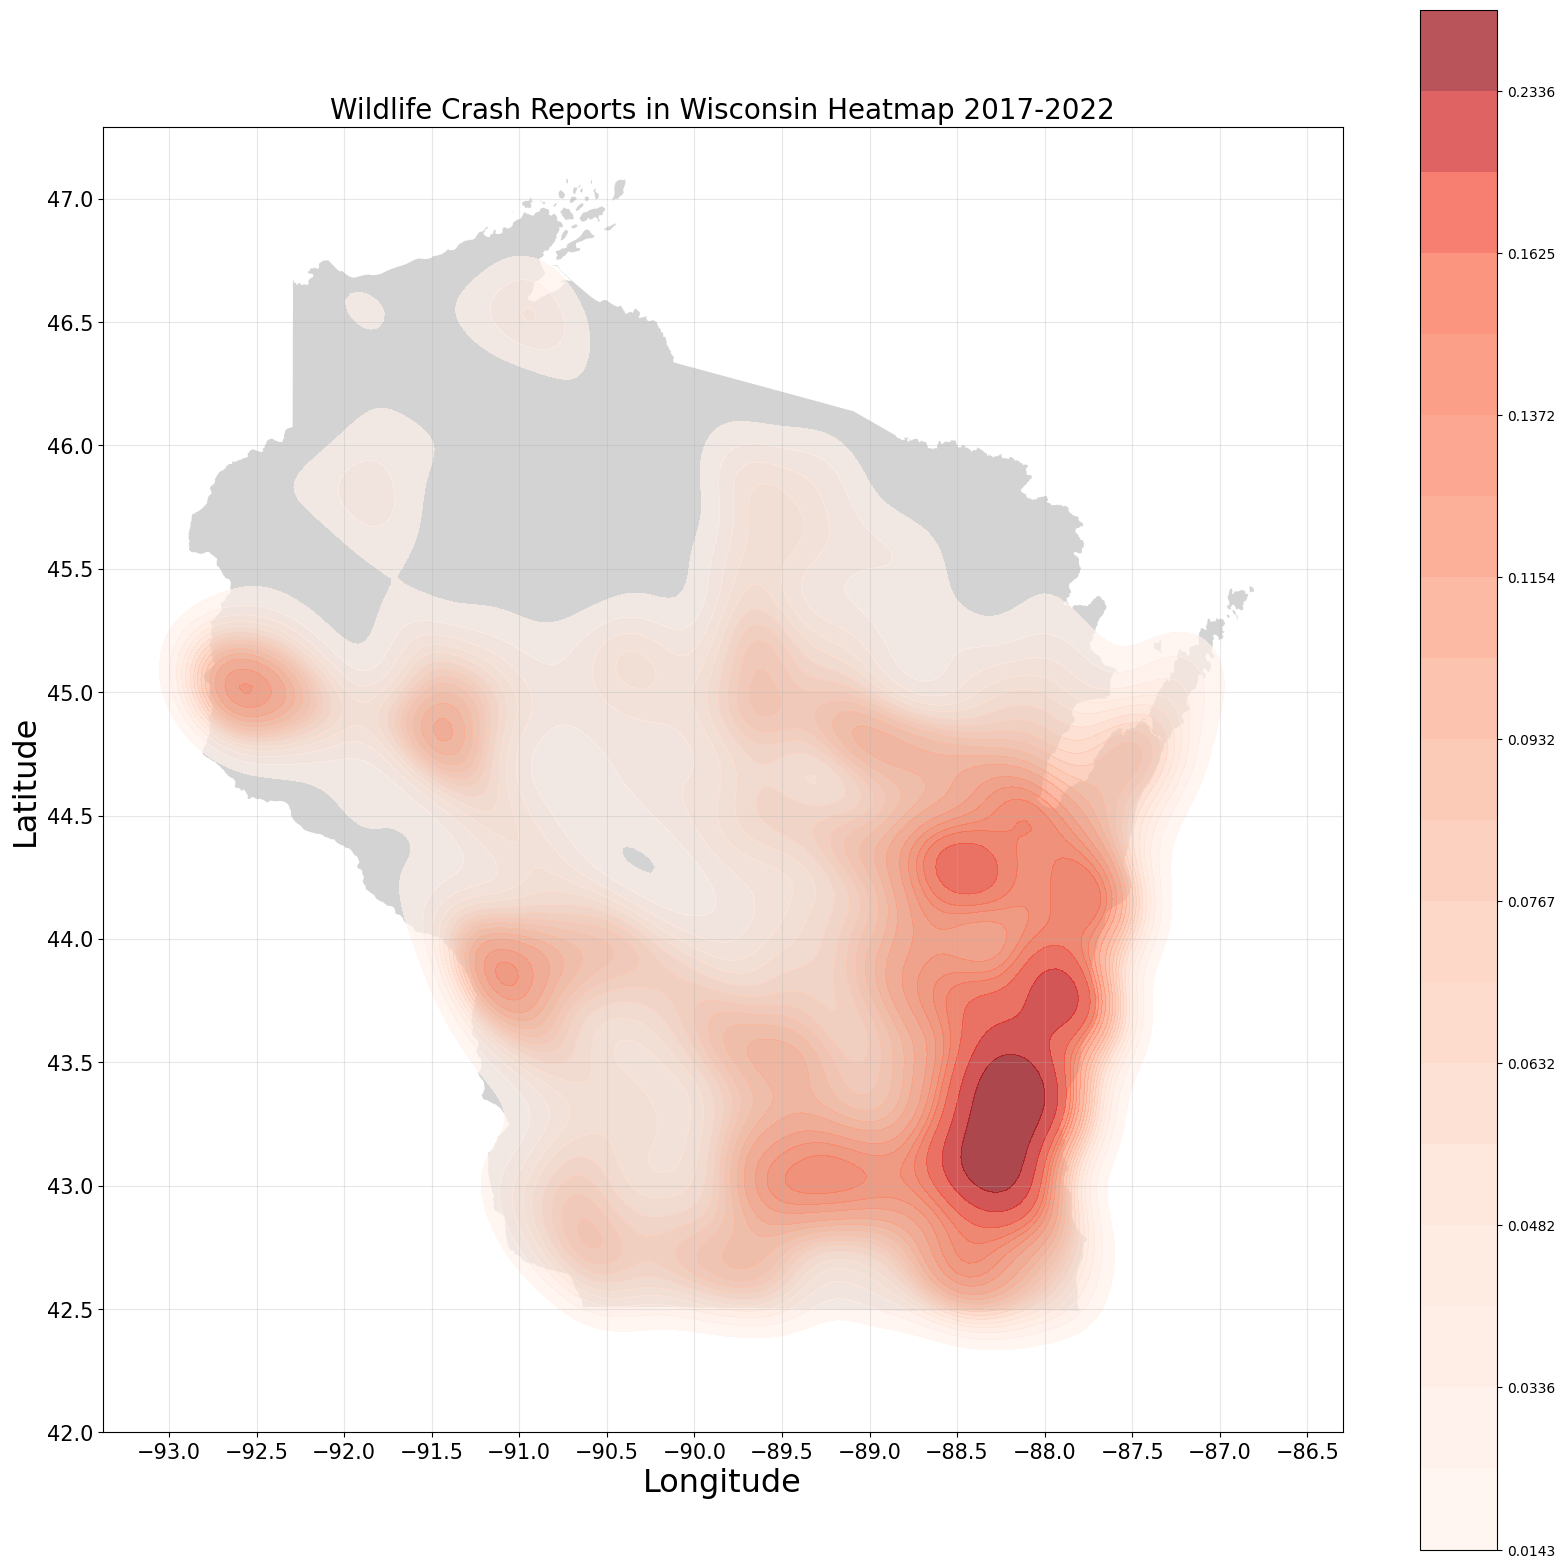

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
BareWi.plot(ax=ax, color="lightgray")

p = sns.kdeplot(ax = ax,
                data = wicord,
                x = "LONDECDG",
                y = "LATDECDG",
                #linewidth = .5,
                fill=True,
                cmap='Reds',
                levels=20,
                cbar=True,
                alpha = .7)


ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-93, -86, .5), fontsize=15)
plt.yticks(np.arange(42, 47.1, .5), fontsize=15)
ax.set_title("Wildlife Crash Reports in Wisconsin Heatmap 2017-2022", fontsize=20)
#plt.savefig("Figures/Heat Plot Maps/Wildlife Crash Reports 2017-2022 Wisconsin Heatmap with Deer.jpg")

Text(0.5, 1.0, 'Wildlife Crash Reports in Dane Heatmap 2017-2022 (Deer excluded)')

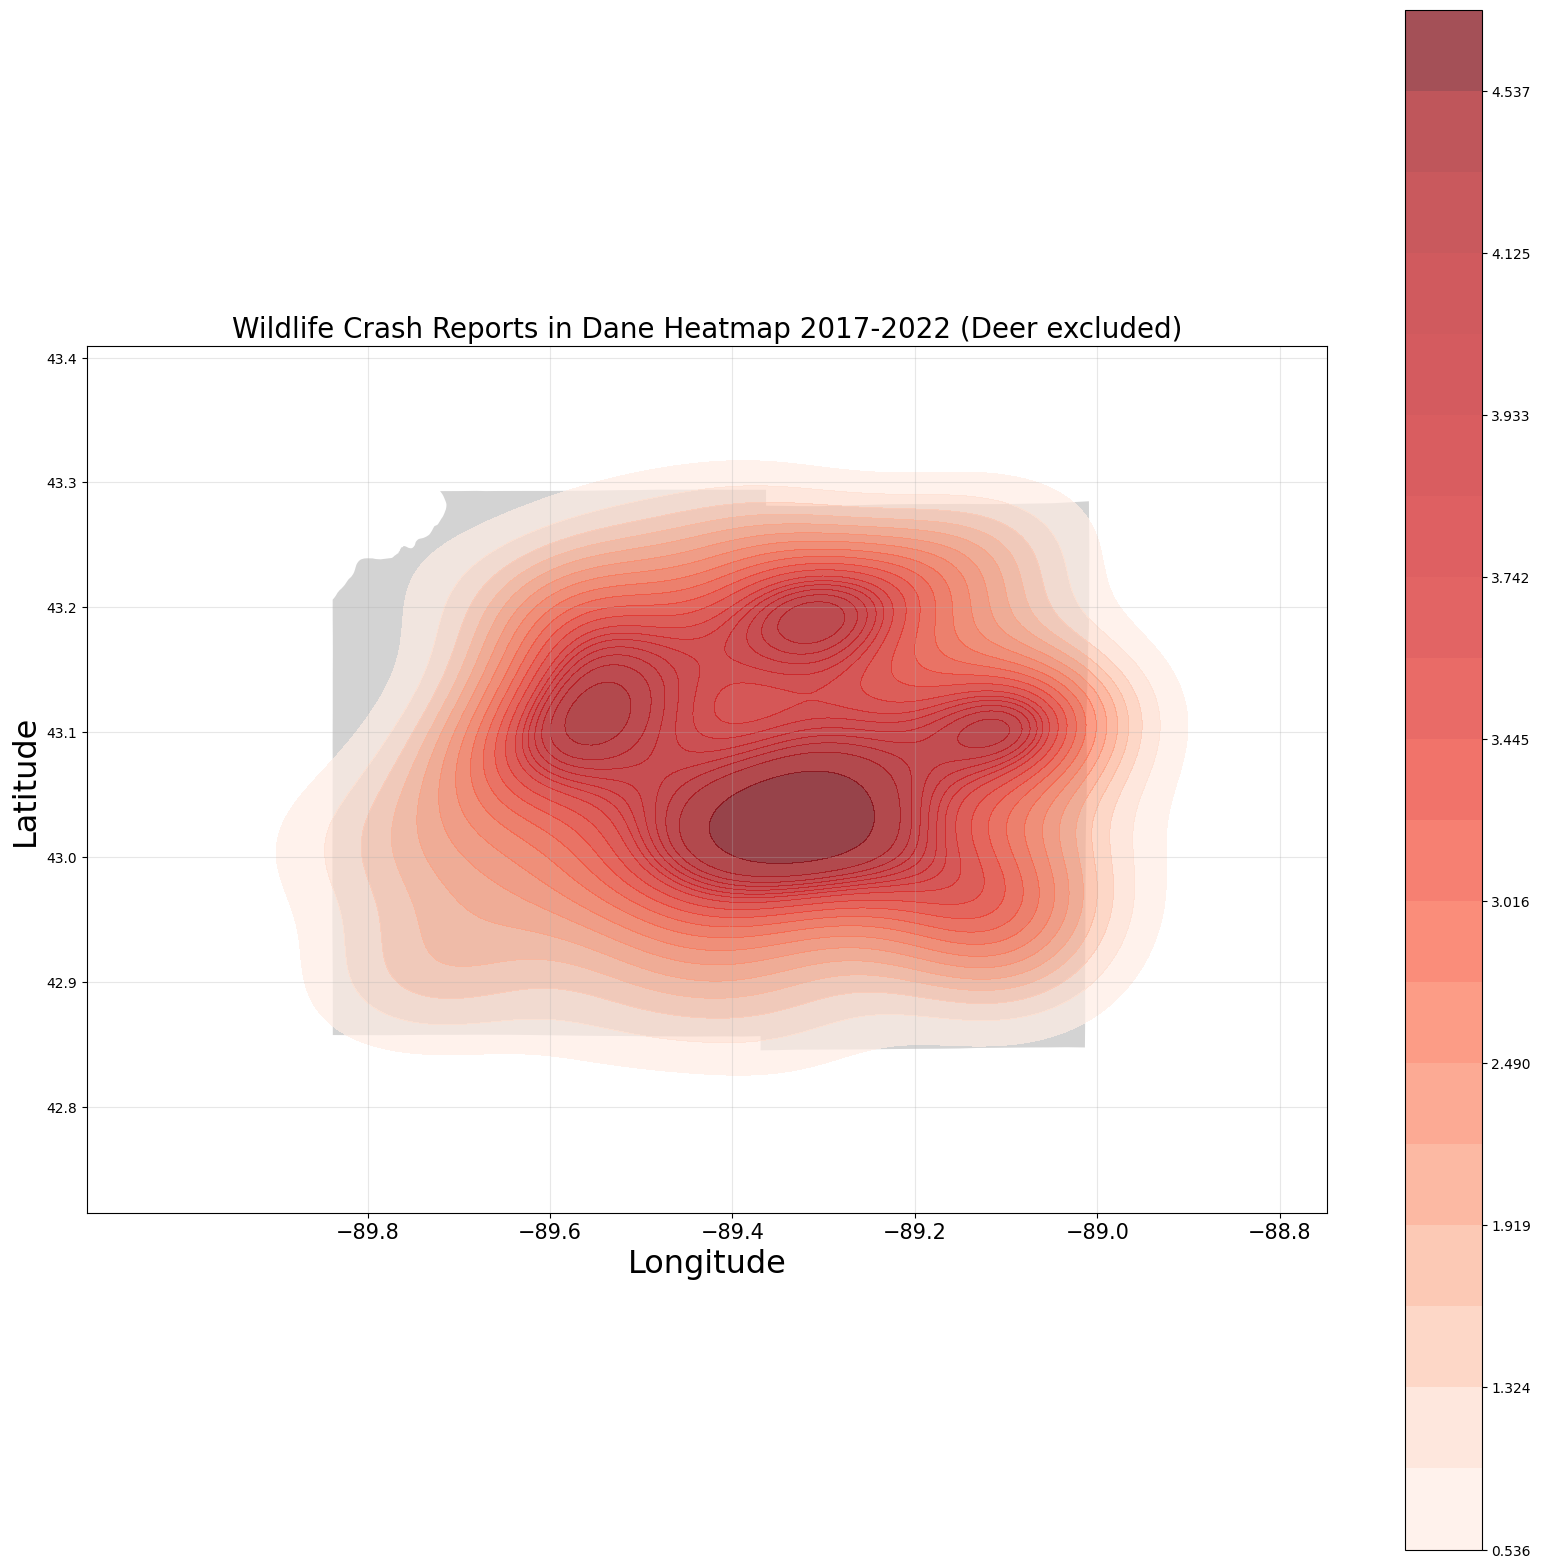

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
Dane_wgs84.plot(ax=ax, color="lightgray")

p = sns.kdeplot(ax = ax,
                data = nodeerdane,
                x = "LONDECDG",
                y = "LATDECDG",
                #linewidth = .5,
                fill=True,
                cmap='Reds',
                levels=20,
                cbar=True,
                #legend=True,
                alpha = .7)


ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-89.8, -88.7, .2), fontsize=15)
ax.set_title("Wildlife Crash Reports in Dane Heatmap 2017-2022 (Deer excluded)", fontsize=20)
#plt.savefig("Figures/Heat Plot Maps/Wildlife Crash Reports 2017-2022 Dane Heatmap no Deer.jpg")

Text(0.5, 1.0, 'Wildlife Crash Reports in Dane Heatmap 2017-2022')

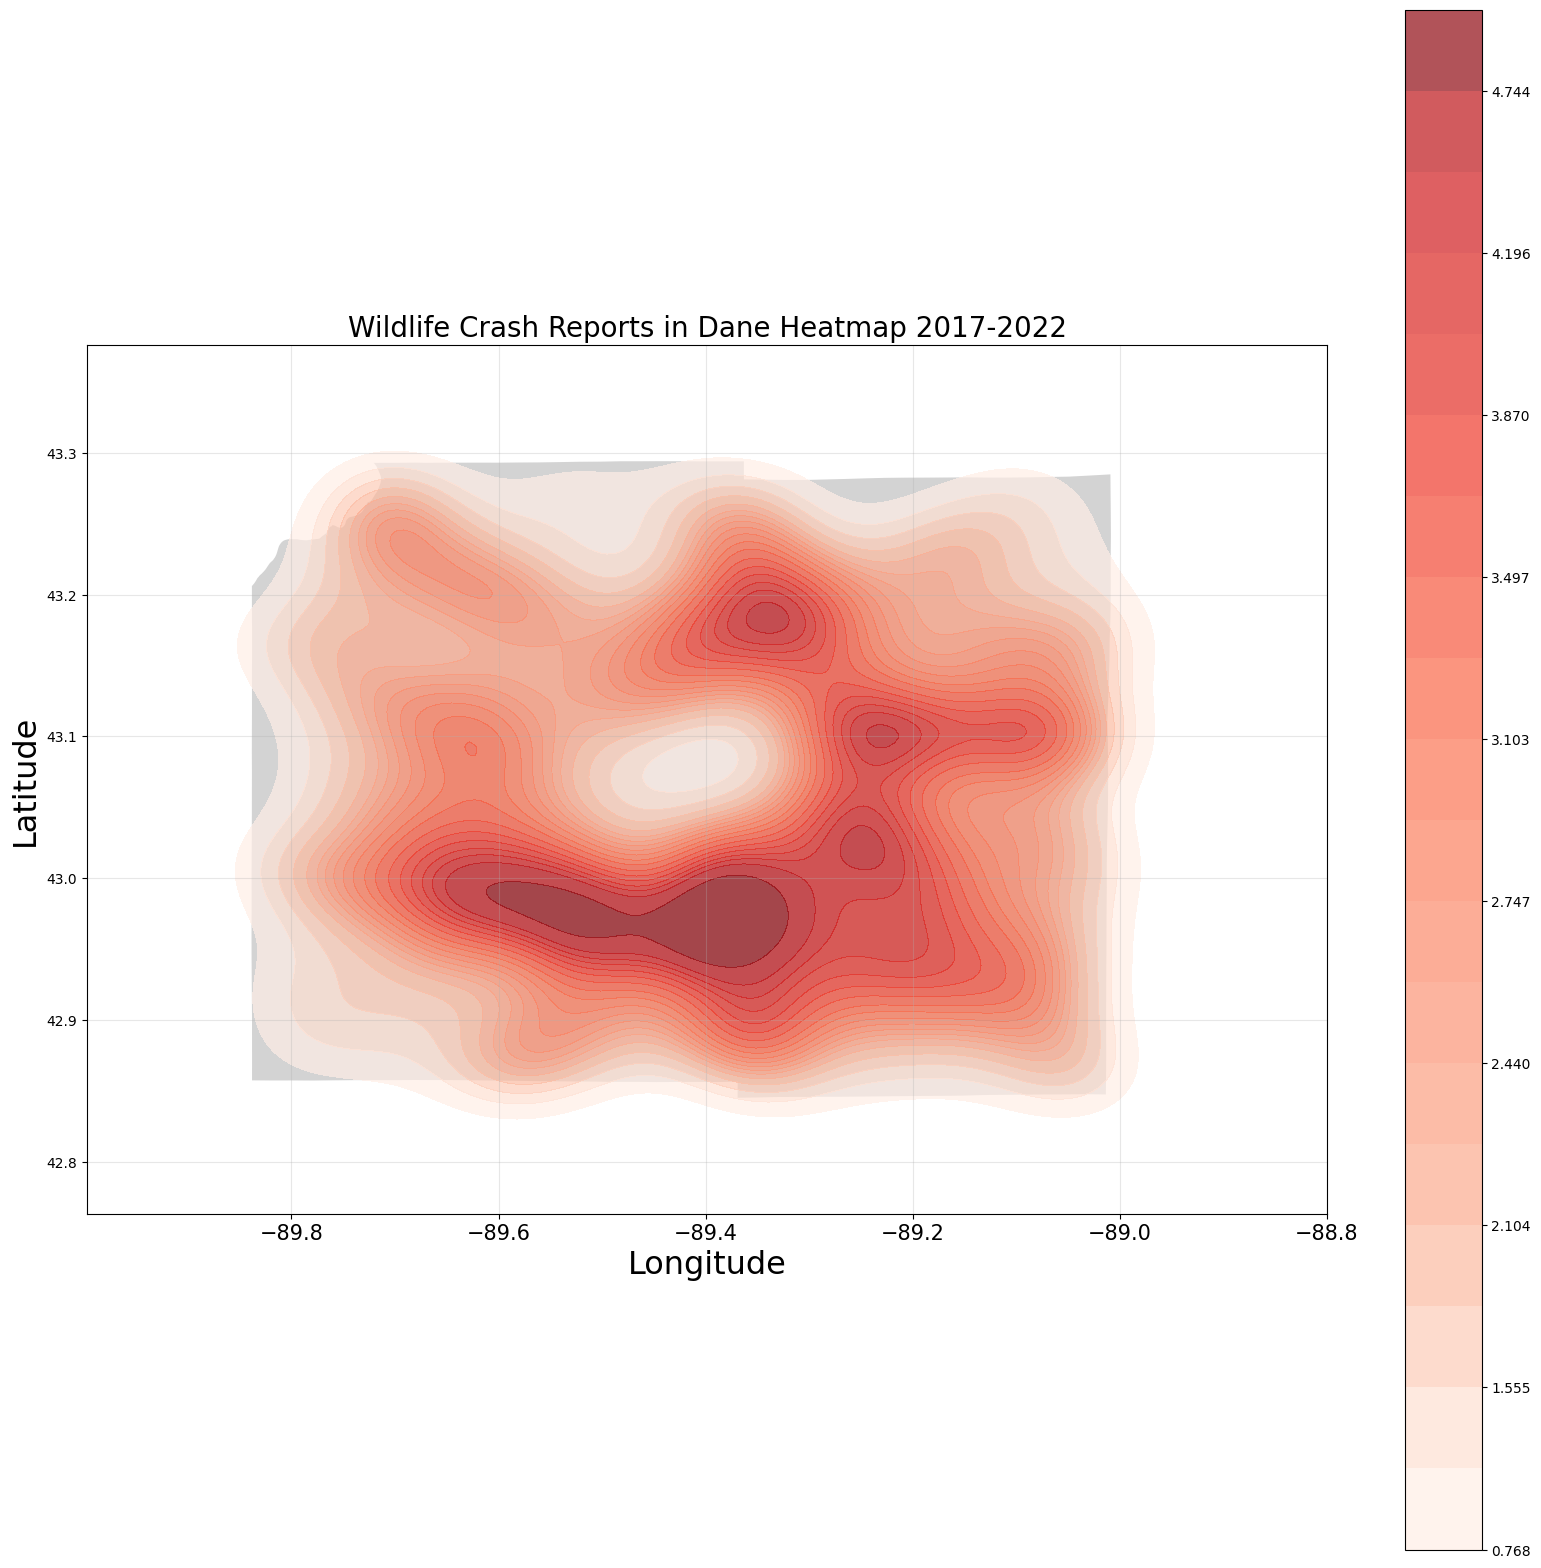

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
Dane_wgs84.plot(ax=ax, color="lightgray")

p = sns.kdeplot(ax = ax,
                data = danecord,
                x = "LONDECDG",
                y = "LATDECDG",
                #linewidth = .5,
                fill=True,
                cmap='Reds',
                levels=20,
                cbar=True,
                #legend=True,
                alpha = .7)


ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(visible=True, alpha=0.3)
plt.xticks(np.arange(-89.8, -88.7, .2), fontsize=15)
ax.set_title("Wildlife Crash Reports in Dane Heatmap 2017-2022", fontsize=20)
#plt.savefig("Figures/Heat Plot Maps/Wildlife Crash Reports 2017-2022 Dane Heatmap with Deer.jpg")

In [20]:
#datasets that include entries lacking GPS data
quicknd = fullwi.drop(fullwi[fullwi.ANMLTY01 == "Deer"].index)
justdane= fullwi.drop(fullwi[fullwi.countyname != "Dane"].index)
qnddane = justdane.drop(justdane[justdane.ANMLTY01 == "Deer"].index)

justrac = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Raccoon(s)"].index)
justop = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Opossum"].index)
justcoy = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Coyote"].index)
justtur = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Turkey"].index)
justbear =  fullwi.drop(fullwi[fullwi.ANMLTY01 != "Bear"].index)
justnon = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Other Non Domesticated"].index)
justdeer2 = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Deer"].index)

[Text(0, 0, '2941'),
 Text(0, 0, '2613'),
 Text(0, 0, '2531'),
 Text(0, 0, '2252'),
 Text(0, 0, '2240'),
 Text(0, 0, '1845'),
 Text(0, 0, '1695'),
 Text(0, 0, '1602'),
 Text(0, 0, '1590'),
 Text(0, 0, '1579'),
 Text(0, 0, '1534'),
 Text(0, 0, '1528'),
 Text(0, 0, '1523'),
 Text(0, 0, '1512'),
 Text(0, 0, '1500'),
 Text(0, 0, '1470'),
 Text(0, 0, '1460'),
 Text(0, 0, '1448'),
 Text(0, 0, '1429'),
 Text(0, 0, '1422')]

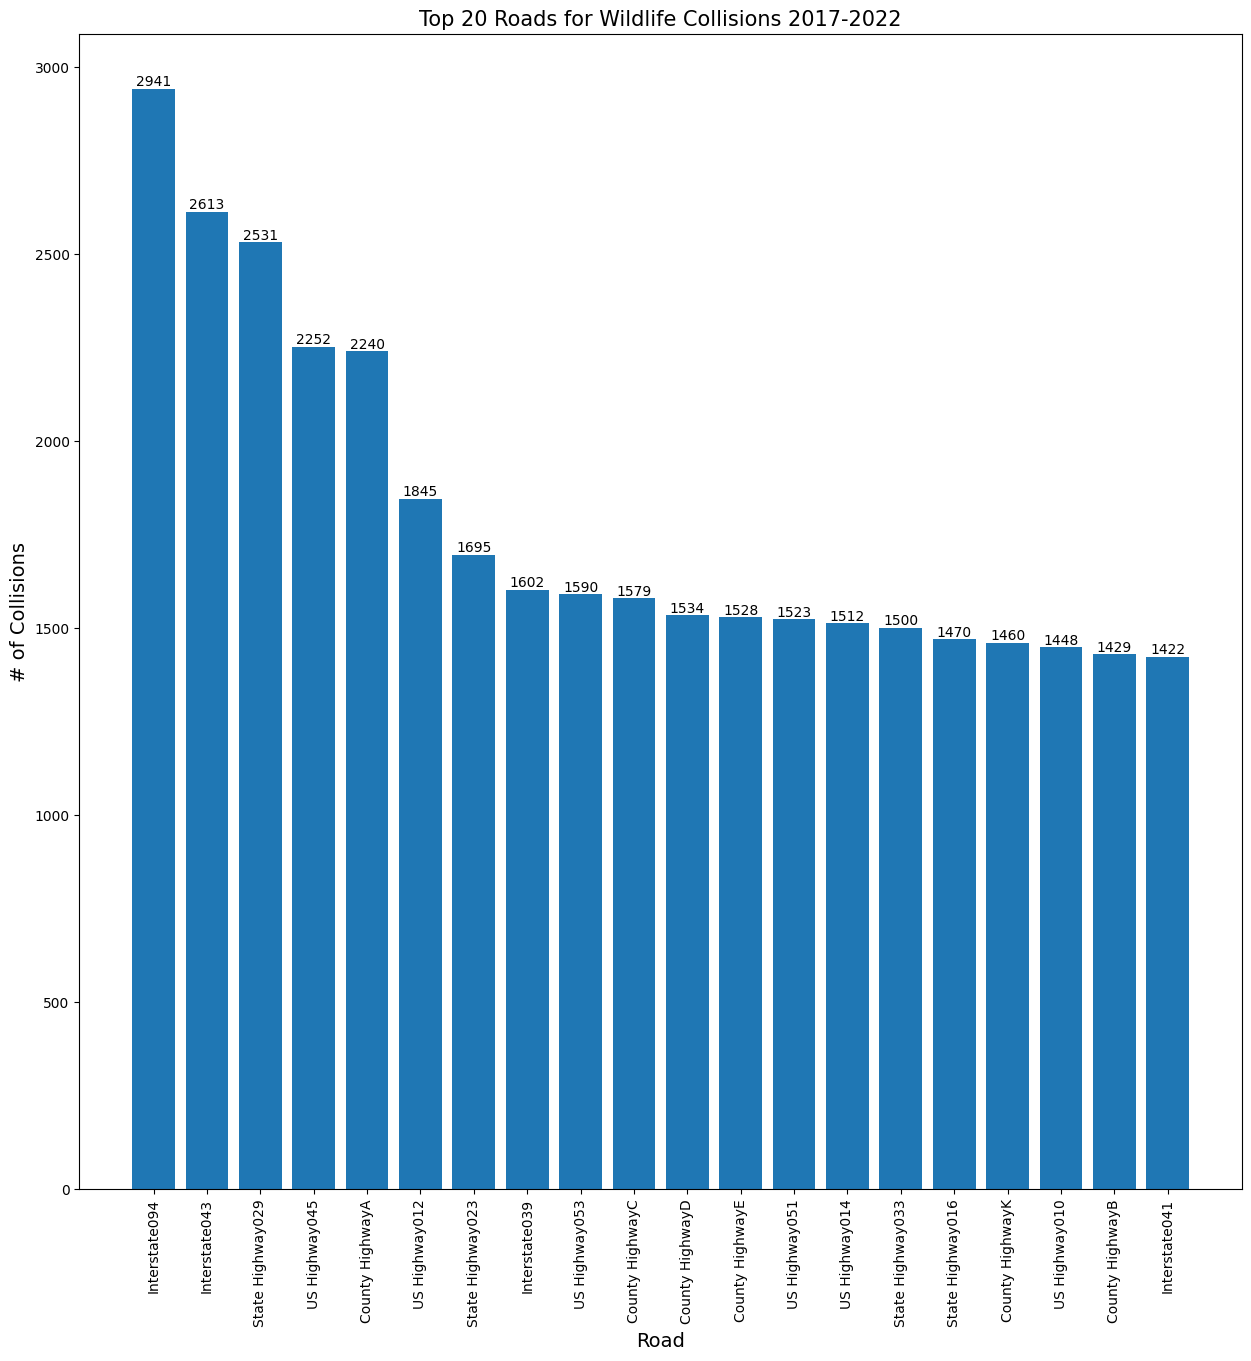

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
y = fullwi.Road.value_counts().sort_values(ascending=False)[:20]
x = y.index
bar1 = ax.bar(x,y)
ax.set_title("Top 20 Roads for Wildlife Collisions 2017-2022", fontsize=15)
ax.set_xlabel("Road", fontsize=14),
ax.set_ylabel("# of Collisions", fontsize=14)
plt.xticks(rotation = 90)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Location/Top 20 Roads for Wildlife Collisions in Wisconsin.jpg")

[Text(0, 0, '190'),
 Text(0, 0, '150'),
 Text(0, 0, '146'),
 Text(0, 0, '129'),
 Text(0, 0, '86'),
 Text(0, 0, '85'),
 Text(0, 0, '78'),
 Text(0, 0, '78'),
 Text(0, 0, '67'),
 Text(0, 0, '65'),
 Text(0, 0, '58'),
 Text(0, 0, '53'),
 Text(0, 0, '48'),
 Text(0, 0, '47'),
 Text(0, 0, '47'),
 Text(0, 0, '44'),
 Text(0, 0, '44'),
 Text(0, 0, '42'),
 Text(0, 0, '41'),
 Text(0, 0, '41')]

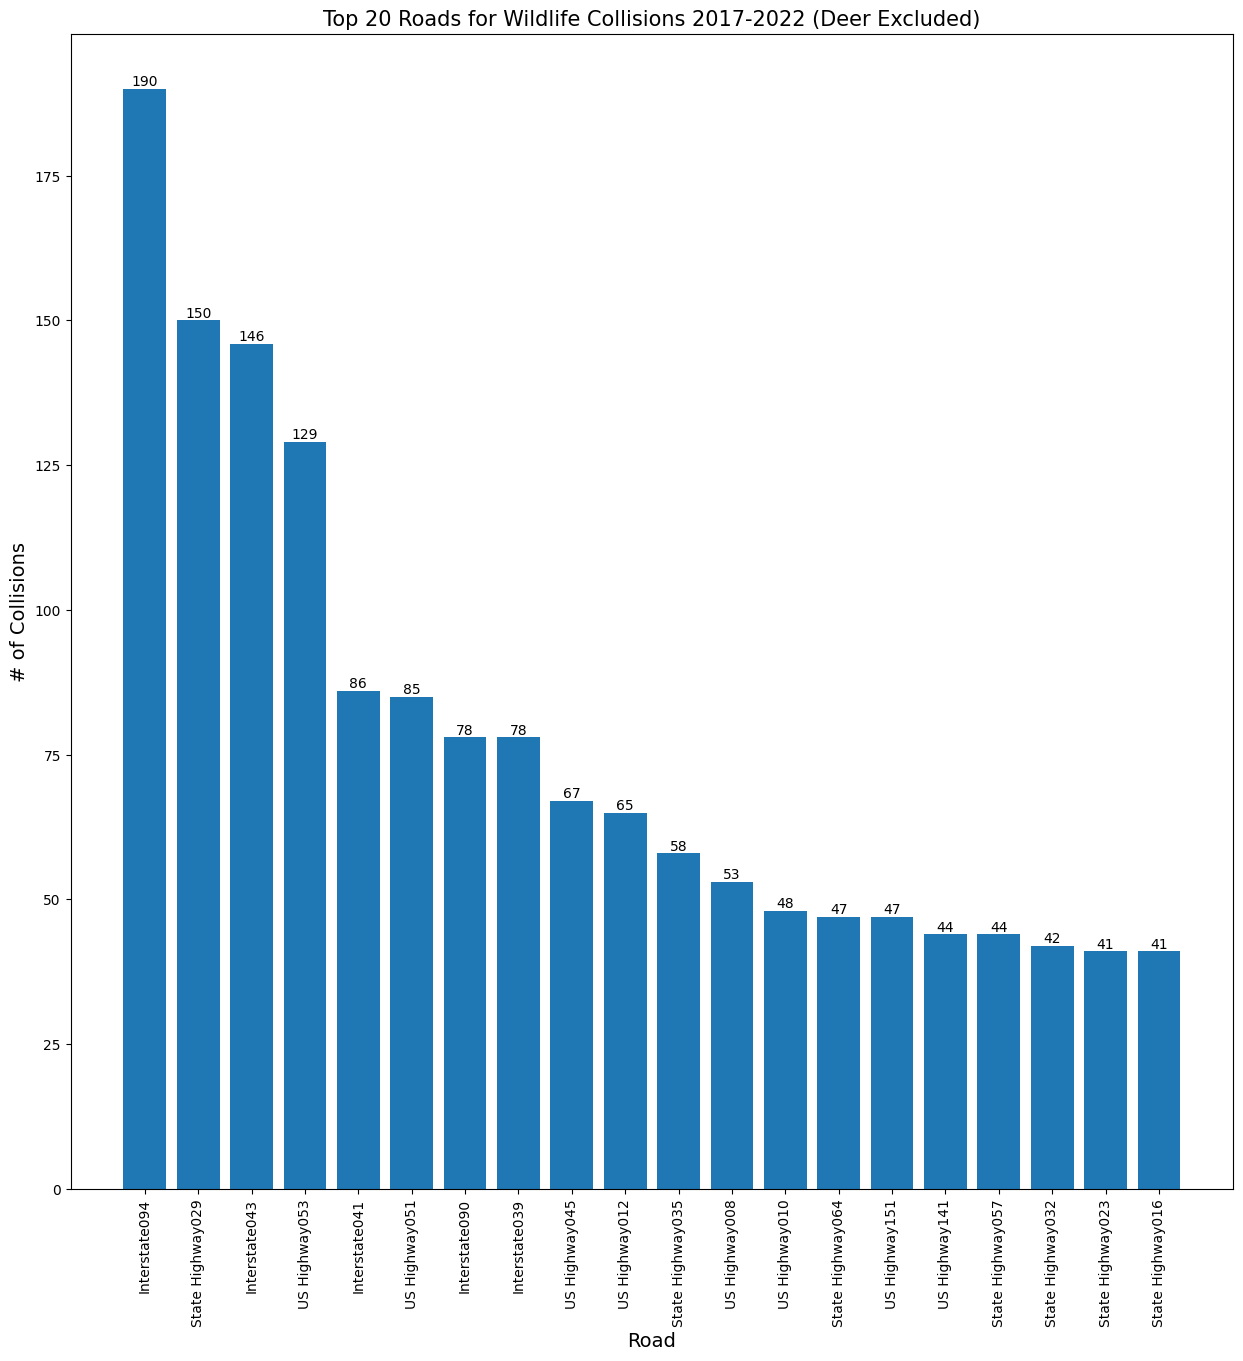

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
y= quicknd.Road.value_counts().sort_values(ascending=False)[:20]
x= y.index

bar1= ax.bar(x,y)
ax.set_title("Top 20 Roads for Wildlife Collisions 2017-2022 (Deer Excluded)", fontsize=15)
ax.set_xlabel("Road", fontsize=14),
ax.set_ylabel("# of Collisions", fontsize=14)
plt.xticks(rotation = 90)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Location/Top 20 Roads for Wildlife Collisions in Wisconsin (Deer Excluded).jpg")

[Text(0, 0, '421'),
 Text(0, 0, '327'),
 Text(0, 0, '325'),
 Text(0, 0, '280'),
 Text(0, 0, '242'),
 Text(0, 0, '238'),
 Text(0, 0, '198'),
 Text(0, 0, '167'),
 Text(0, 0, '164'),
 Text(0, 0, '163'),
 Text(0, 0, '141'),
 Text(0, 0, '122'),
 Text(0, 0, '113'),
 Text(0, 0, '110'),
 Text(0, 0, '107'),
 Text(0, 0, '91'),
 Text(0, 0, '91'),
 Text(0, 0, '85'),
 Text(0, 0, '83'),
 Text(0, 0, '81')]

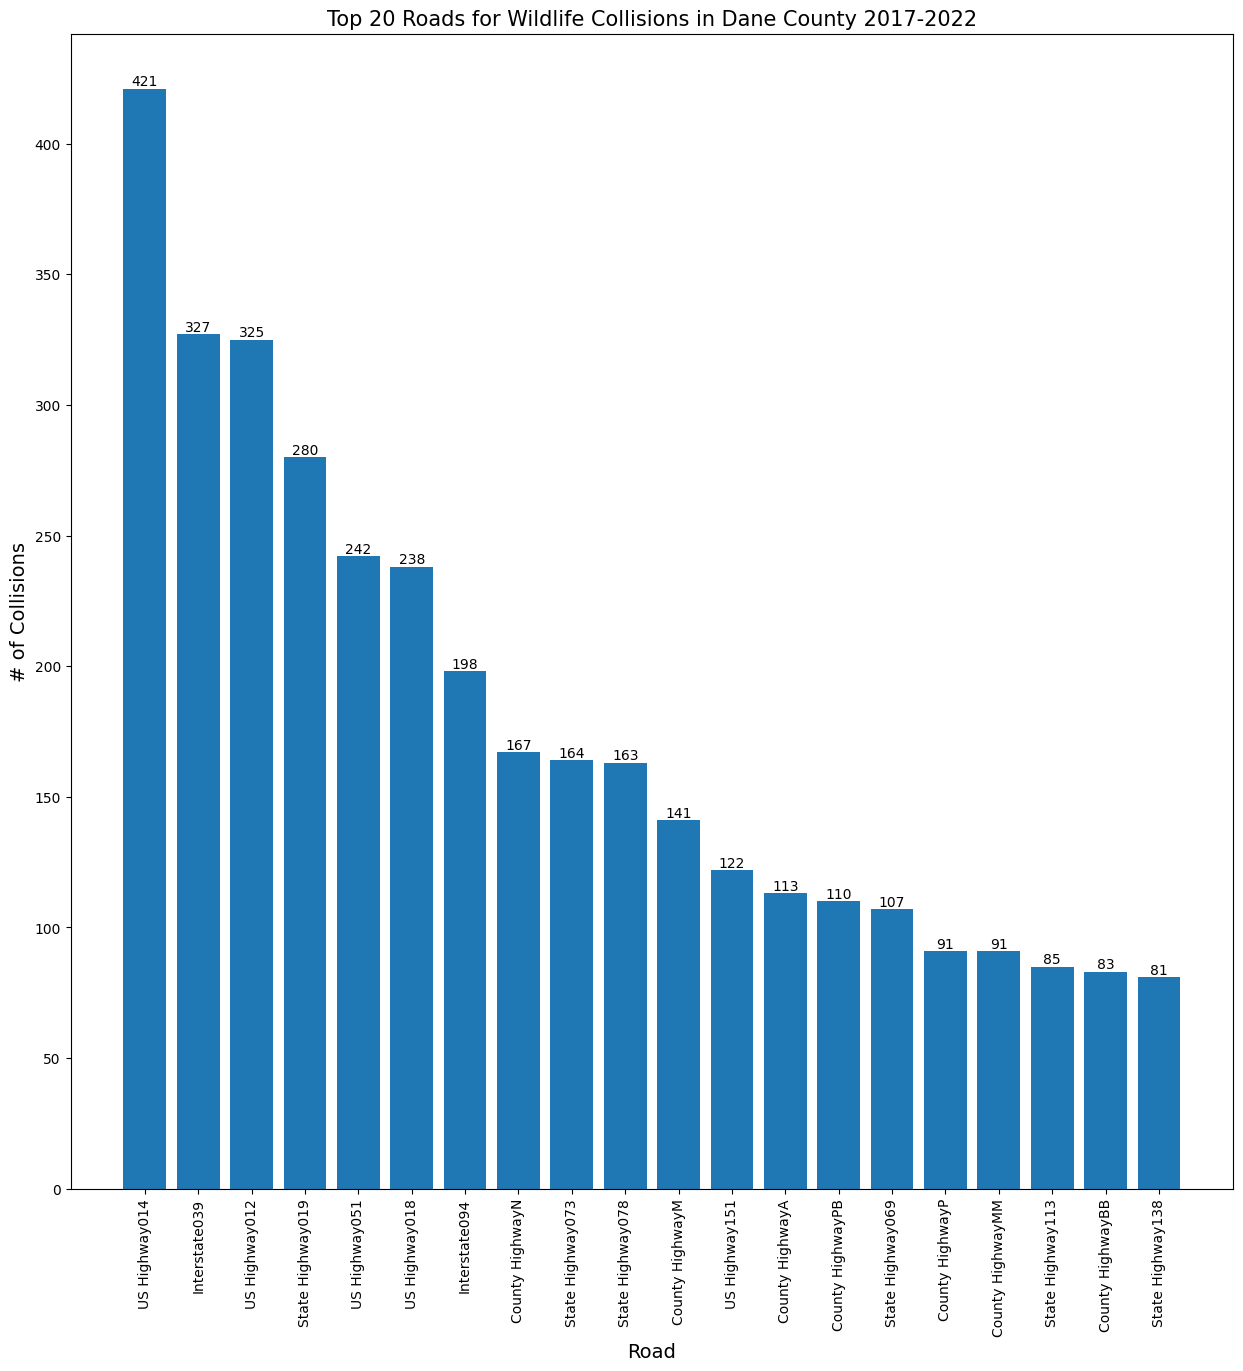

In [23]:
fix, ax = plt.subplots(figsize=(15,15))
y = justdane.Road.value_counts().sort_values(ascending=False)[:20]
x = y.index

bar1= ax.bar(x,y)
ax.set_title("Top 20 Roads for Wildlife Collisions in Dane County 2017-2022", fontsize=15)
ax.set_xlabel("Road", fontsize=14),
ax.set_ylabel("# of Collisions", fontsize=14)
plt.xticks(rotation = 90)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Location/Top 20 Roads for Wildlife Collisions in Dane County.jpg")

[Text(0, 0, '20'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '10'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2')]

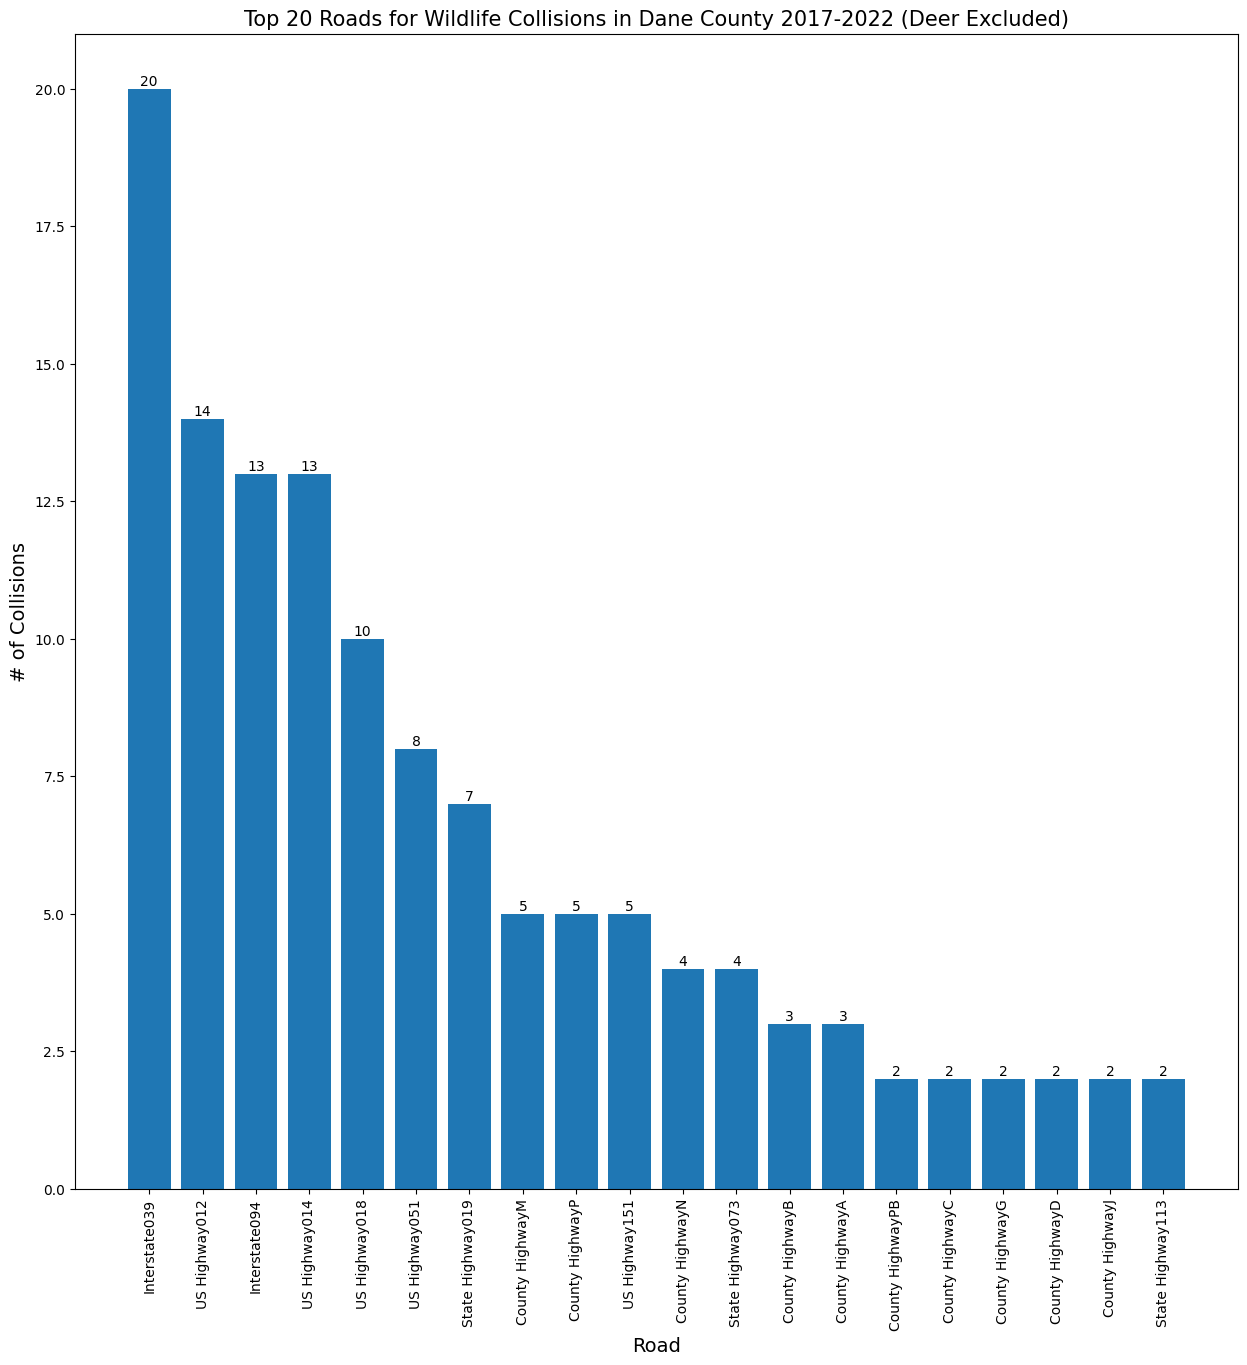

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
y= qnddane.Road.value_counts().sort_values(ascending=False)[:20]
x= y.index

bar1= ax.bar(x,y)
ax.set_title("Top 20 Roads for Wildlife Collisions in Dane County 2017-2022 (Deer Excluded)", fontsize=15)
ax.set_xlabel("Road", fontsize=14),
ax.set_ylabel("# of Collisions", fontsize=14)
plt.xticks(rotation = 90)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Location/Top 20 Roads for Wildlife Collisions in Dane County (Deer Excluded).jpg")

[Text(0, 0, '7783'),
 Text(0, 0, '5181'),
 Text(0, 0, '6111'),
 Text(0, 0, '6124'),
 Text(0, 0, '9814'),
 Text(0, 0, '10905'),
 Text(0, 0, '6449'),
 Text(0, 0, '4632'),
 Text(0, 0, '7192'),
 Text(0, 0, '16536'),
 Text(0, 0, '21337'),
 Text(0, 0, '9295')]

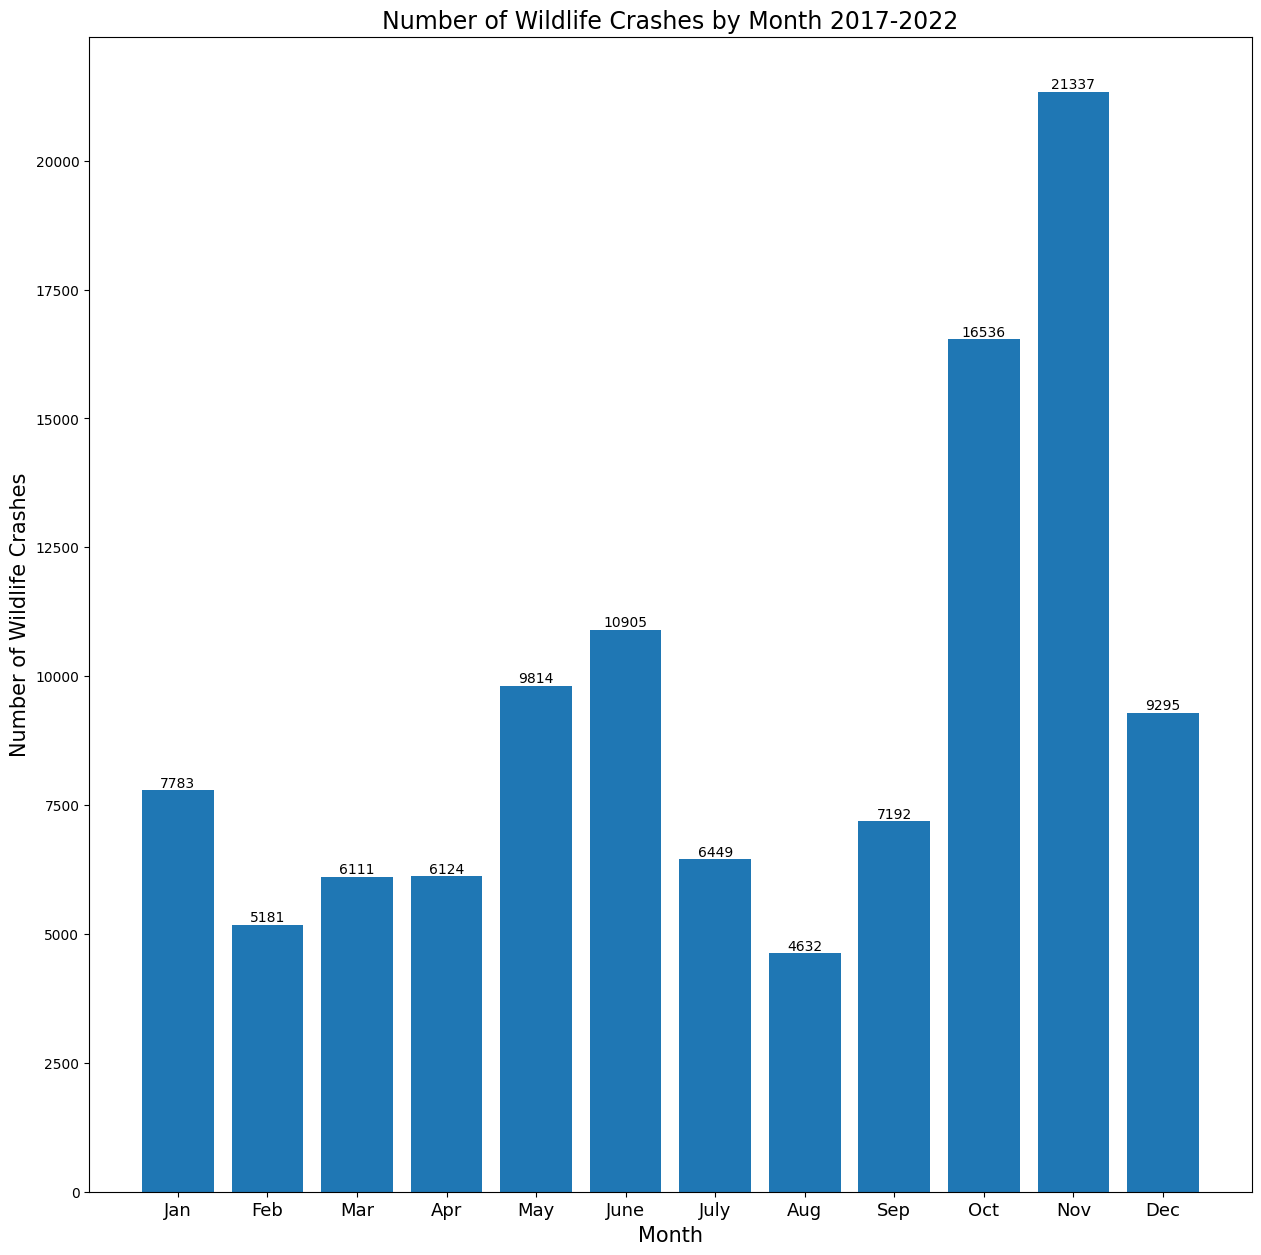

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
y= fullwi.nummonth.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y)

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=13)

ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Month", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Month 2017-2022", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Month.jpg")

[Text(0, 0, '131'),
 Text(0, 0, '125'),
 Text(0, 0, '239'),
 Text(0, 0, '486'),
 Text(0, 0, '469'),
 Text(0, 0, '327'),
 Text(0, 0, '260'),
 Text(0, 0, '205'),
 Text(0, 0, '261'),
 Text(0, 0, '376'),
 Text(0, 0, '257'),
 Text(0, 0, '150')]

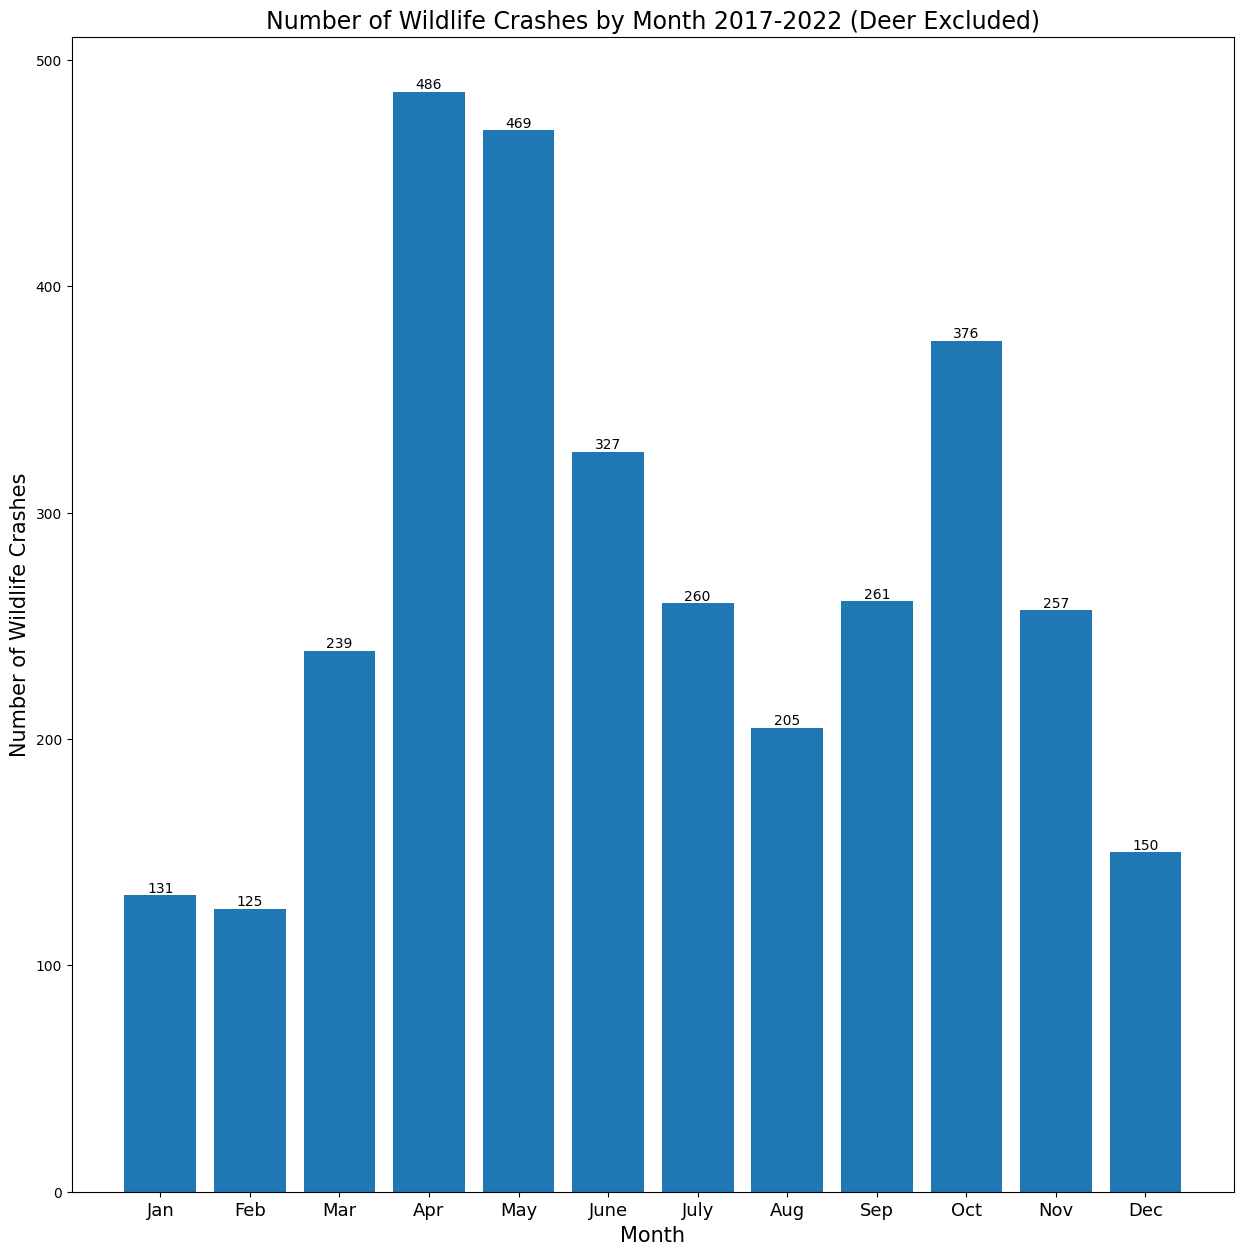

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
y= quicknd.nummonth.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y)

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=13)
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Month", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Month 2017-2022 (Deer Excluded)", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Month (Deer Excluded).jpg")

[Text(0, 0, '369'),
 Text(0, 0, '242'),
 Text(0, 0, '314'),
 Text(0, 0, '306'),
 Text(0, 0, '543'),
 Text(0, 0, '485'),
 Text(0, 0, '252'),
 Text(0, 0, '170'),
 Text(0, 0, '245'),
 Text(0, 0, '884'),
 Text(0, 0, '1099'),
 Text(0, 0, '486')]

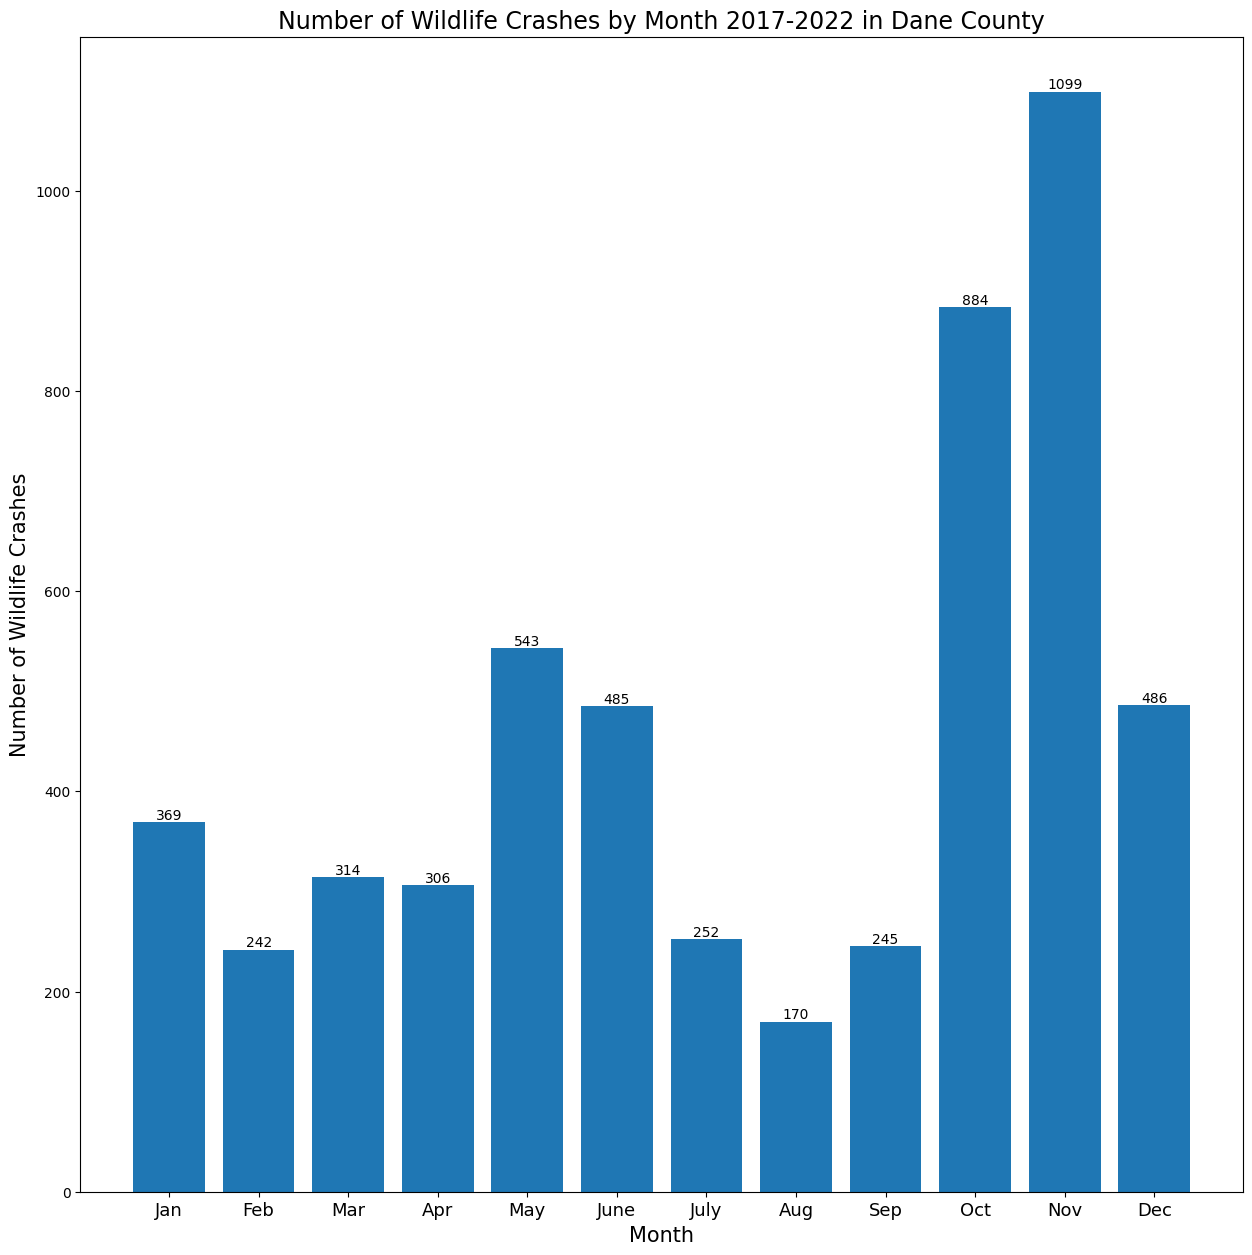

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
y= justdane.nummonth.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y)

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=13)

ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Month", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Month 2017-2022 in Dane County", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Month in Dane County.jpg")

[Text(0, 0, '9'),
 Text(0, 0, '6'),
 Text(0, 0, '18'),
 Text(0, 0, '26'),
 Text(0, 0, '25'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '7'),
 Text(0, 0, '5'),
 Text(0, 0, '14'),
 Text(0, 0, '7'),
 Text(0, 0, '12')]

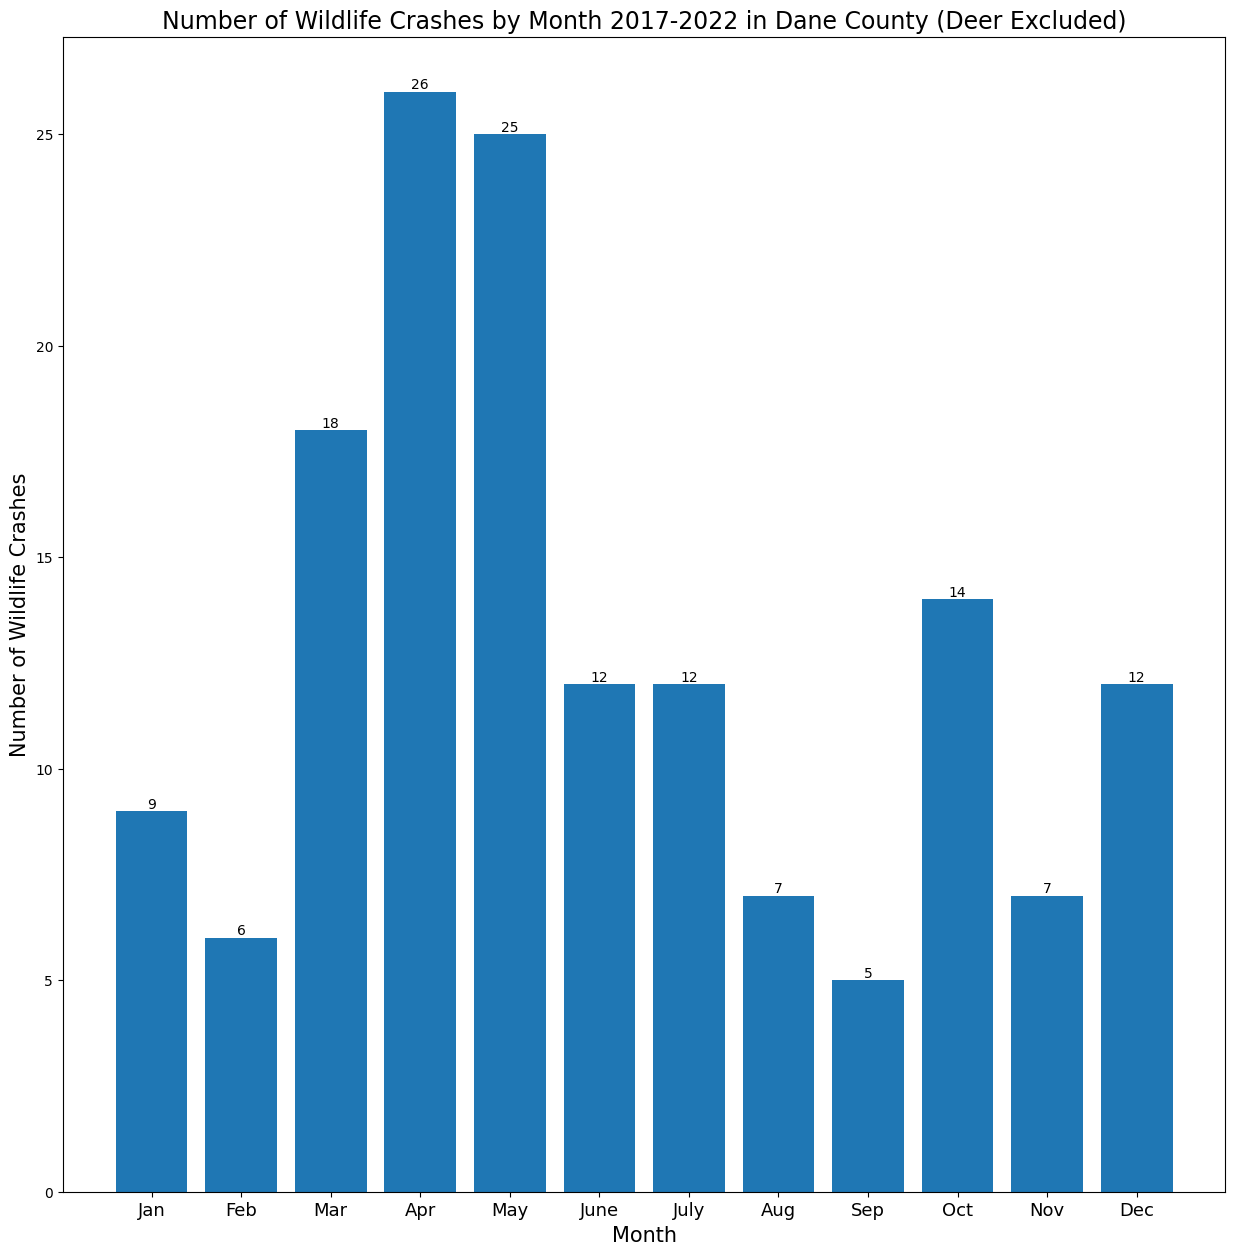

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
y= qnddane.nummonth.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y)

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=13)

ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Month", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Month 2017-2022 in Dane County (Deer Excluded)", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Month in Dane County (Deer Excluded).jpg")

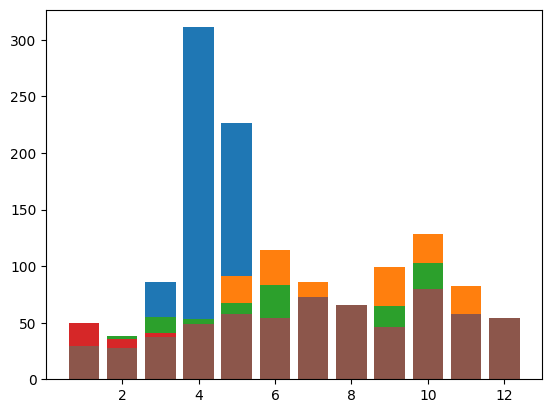

In [29]:
#########################################################################
#setup for the graph
y= justtur.nummonth.value_counts().sort_index()
x= y.index
bar1= plt.bar(x,y)
y= justbear.nummonth.value_counts().sort_index()
x= y.index
bar2= plt.bar(x,y)
y= justrac.nummonth.value_counts().sort_index()
x= y.index
bar3= plt.bar(x,y)
y= justcoy.nummonth.value_counts().sort_index()
x= y.index
bar4= plt.bar(x,y)
y= justop.nummonth.value_counts().sort_index()
x= y.index
bar5= plt.bar(x,y)
y= justnon.nummonth.value_counts().sort_index()
x= y.index
bar6= plt.bar(x,y)

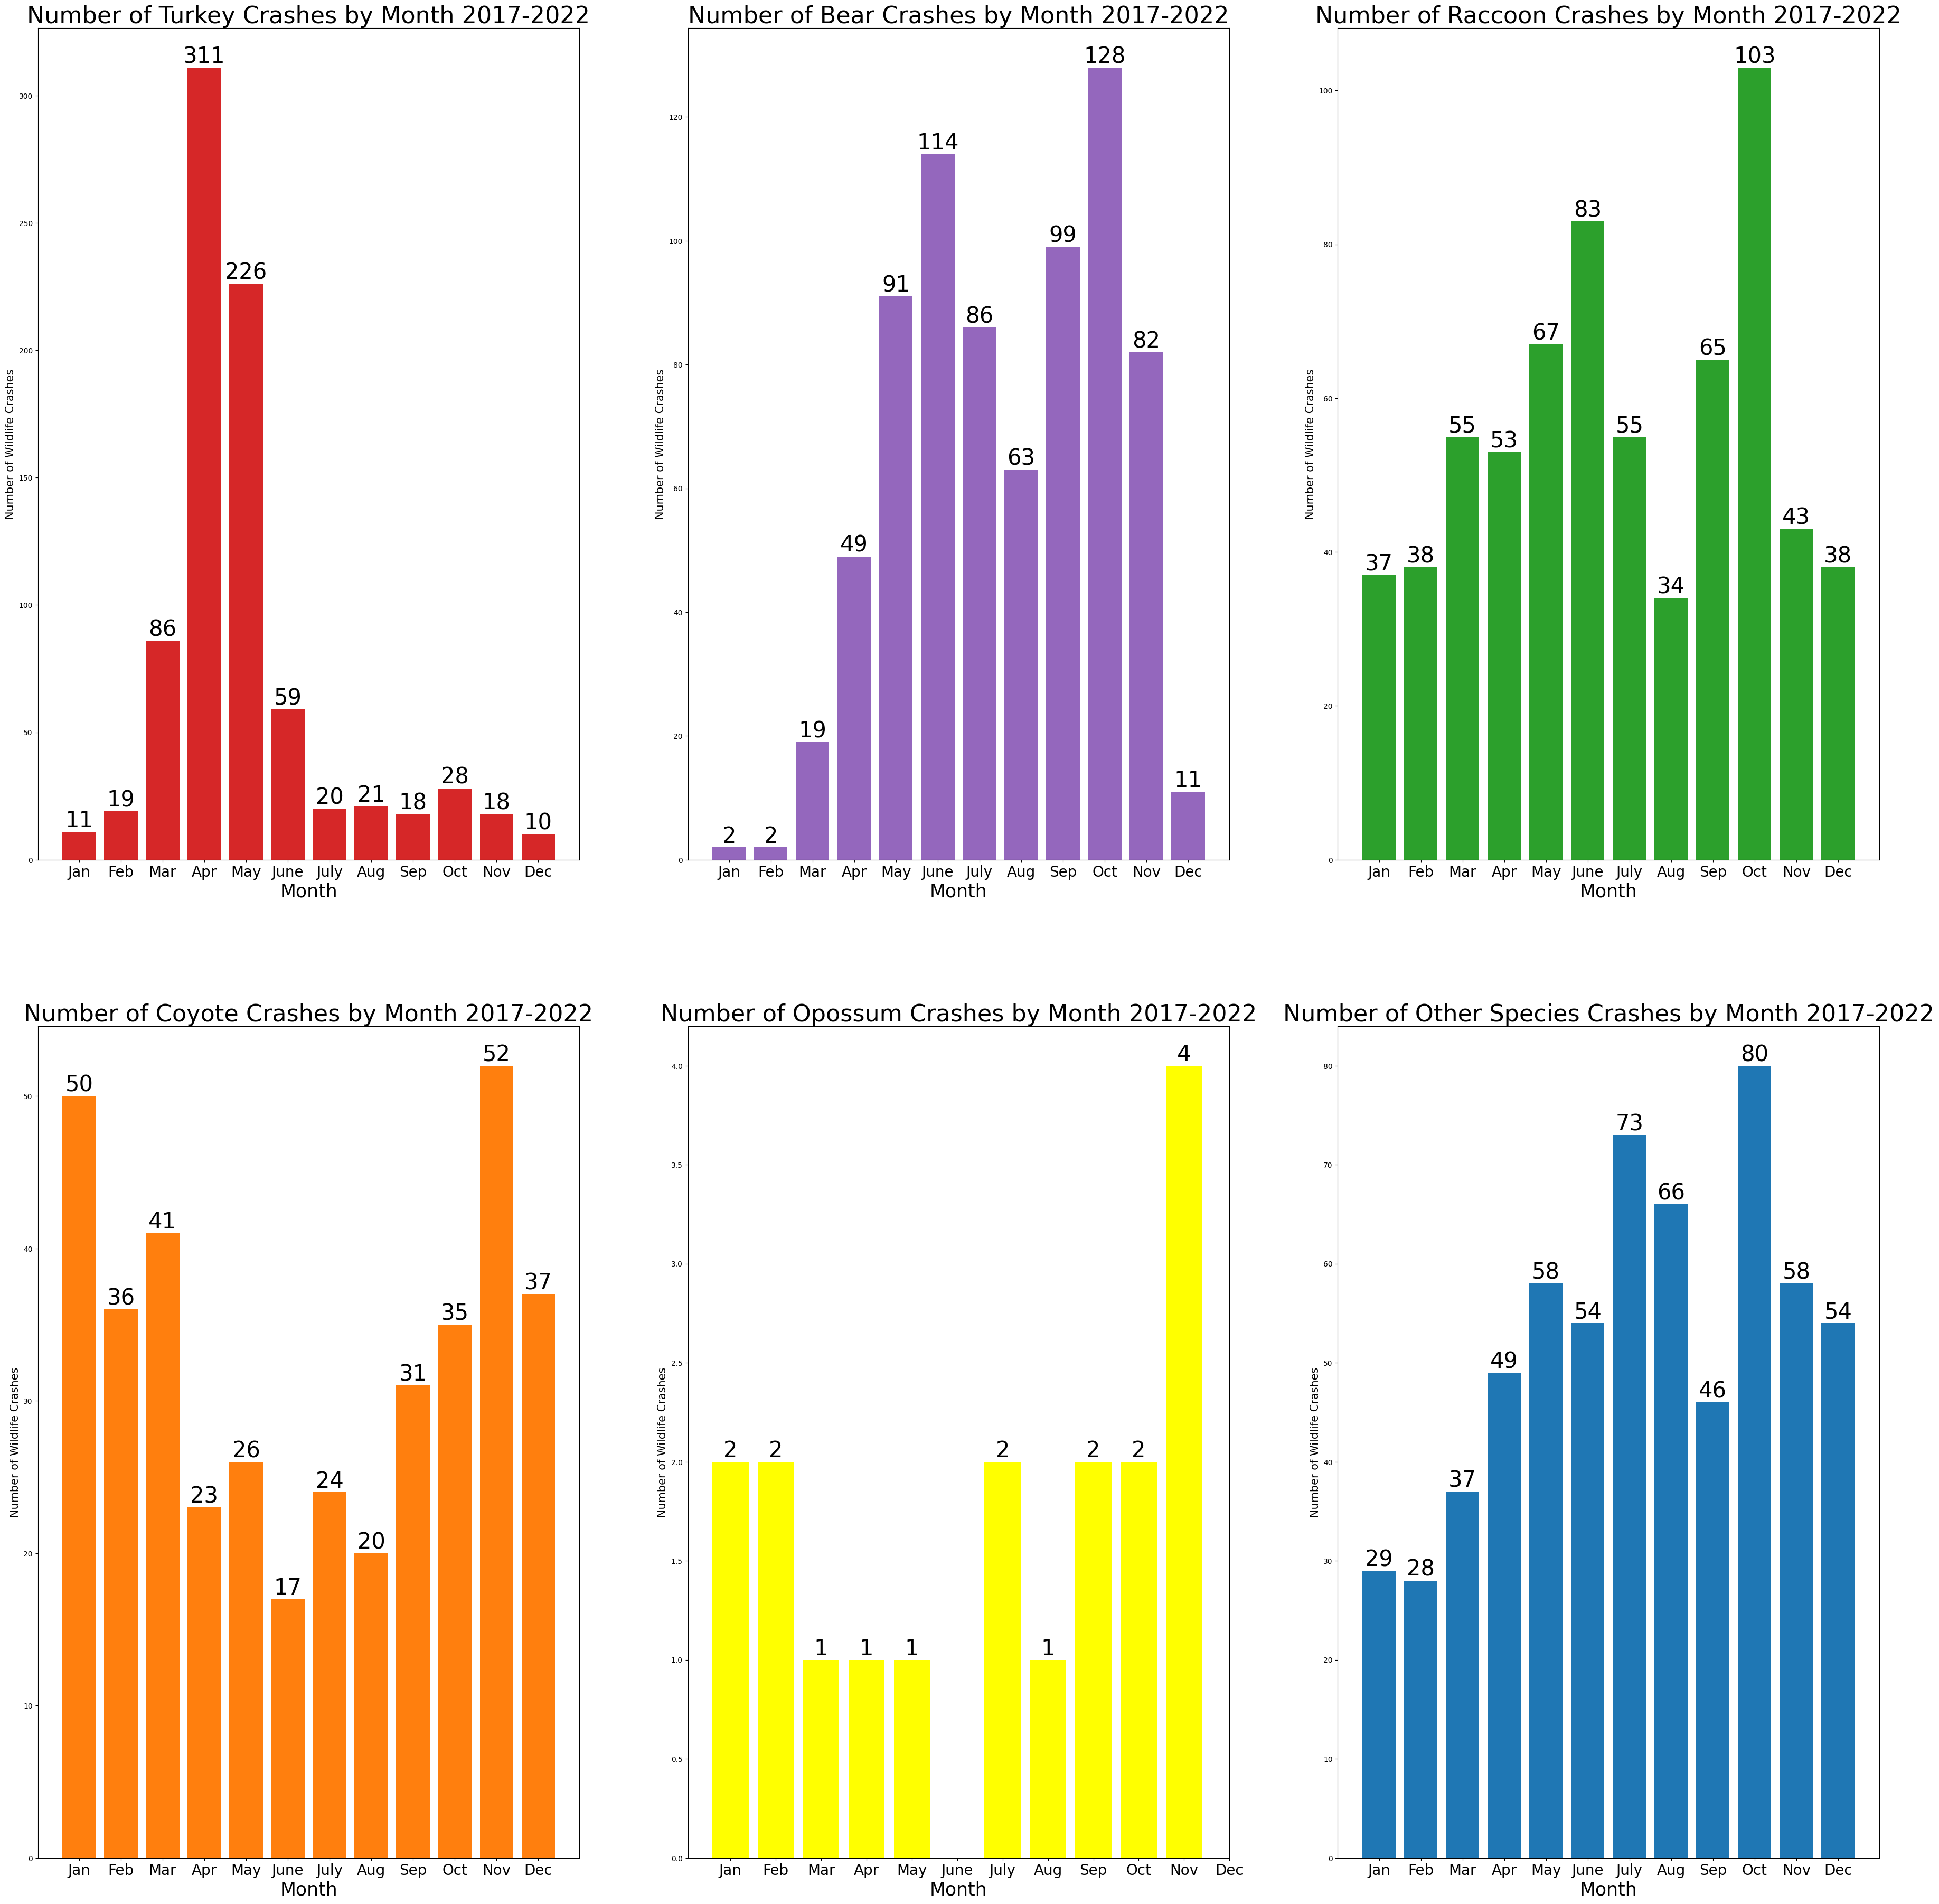

In [30]:
fig, ax = plt.subplots(2,3, figsize=(45,45))
#fig, ax = plt.subplots(figsize=(15,15))
y= justtur.nummonth.value_counts().sort_index()
x= y.index
ax[0,0].bar(x,y, color='tab:red')
ax[0,0].set_xticks(np.arange(1,13))
ax[0,0].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[0,0].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,0].set_xlabel("Month", fontsize=25)
ax[0,0].set_title("Number of Turkey Crashes by Month 2017-2022", fontsize=32)
ax[0,0].bar_label(bar1, fontsize=30)
###
y= justbear.nummonth.value_counts().sort_index()
x= y.index
ax[0,1].bar(x,y, color='tab:purple')
ax[0,1].set_xticks(np.arange(1,13))
ax[0,1].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[0,1].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,1].set_xlabel("Month", fontsize=25)
ax[0,1].set_title("Number of Bear Crashes by Month 2017-2022", fontsize=32)
ax[0,1].bar_label(bar2, fontsize=30)
###
y= justrac.nummonth.value_counts().sort_index()
x= y.index
ax[0,2].bar(x,y, color='tab:green')
ax[0,2].set_xticks(np.arange(1,13))
ax[0,2].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[0,2].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,2].set_xlabel("Month", fontsize=25)
ax[0,2].set_title("Number of Raccoon Crashes by Month 2017-2022", fontsize=32)
ax[0,2].bar_label(bar3, fontsize=30)
###
y= justcoy.nummonth.value_counts().sort_index()
x= y.index
ax[1,0].bar(x,y, color='tab:orange')
ax[1,0].set_xticks(np.arange(1,13))
ax[1,0].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[1,0].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,0].set_xlabel("Month", fontsize=25)
ax[1,0].set_title("Number of Coyote Crashes by Month 2017-2022", fontsize=32)
ax[1,0].bar_label(bar4, fontsize=30)
###
y= justop.nummonth.value_counts().sort_index()
x= y.index
ax[1,1].bar(x,y, color='yellow')
ax[1,1].set_xticks(np.arange(1,13))
ax[1,1].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[1,1].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,1].set_xlabel("Month", fontsize=25)
ax[1,1].set_title("Number of Opossum Crashes by Month 2017-2022", fontsize=32)
ax[1,1].bar_label(bar5, fontsize=30)
###
y= justnon.nummonth.value_counts().sort_index()
x= y.index
ax[1,2].bar(x,y, color='tab:blue')
ax[1,2].set_xticks(np.arange(1,13))
ax[1,2].set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=20)
ax[1,2].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,2].set_xlabel("Month", fontsize=25)
ax[1,2].set_title("Number of Other Species Crashes by Month 2017-2022", fontsize=32)
ax[1,2].bar_label(bar6, fontsize=30)
#plt.savefig("Figures/Bar Graphs/Time/Number of Multi Species Crashes by Month 2017-2022.jpg")
#I recommend opening the .jpg or opening the image in a new tab to see it more clearly

In [ ]:
#^^^ Do the same thing for day of the week? Time of day too?

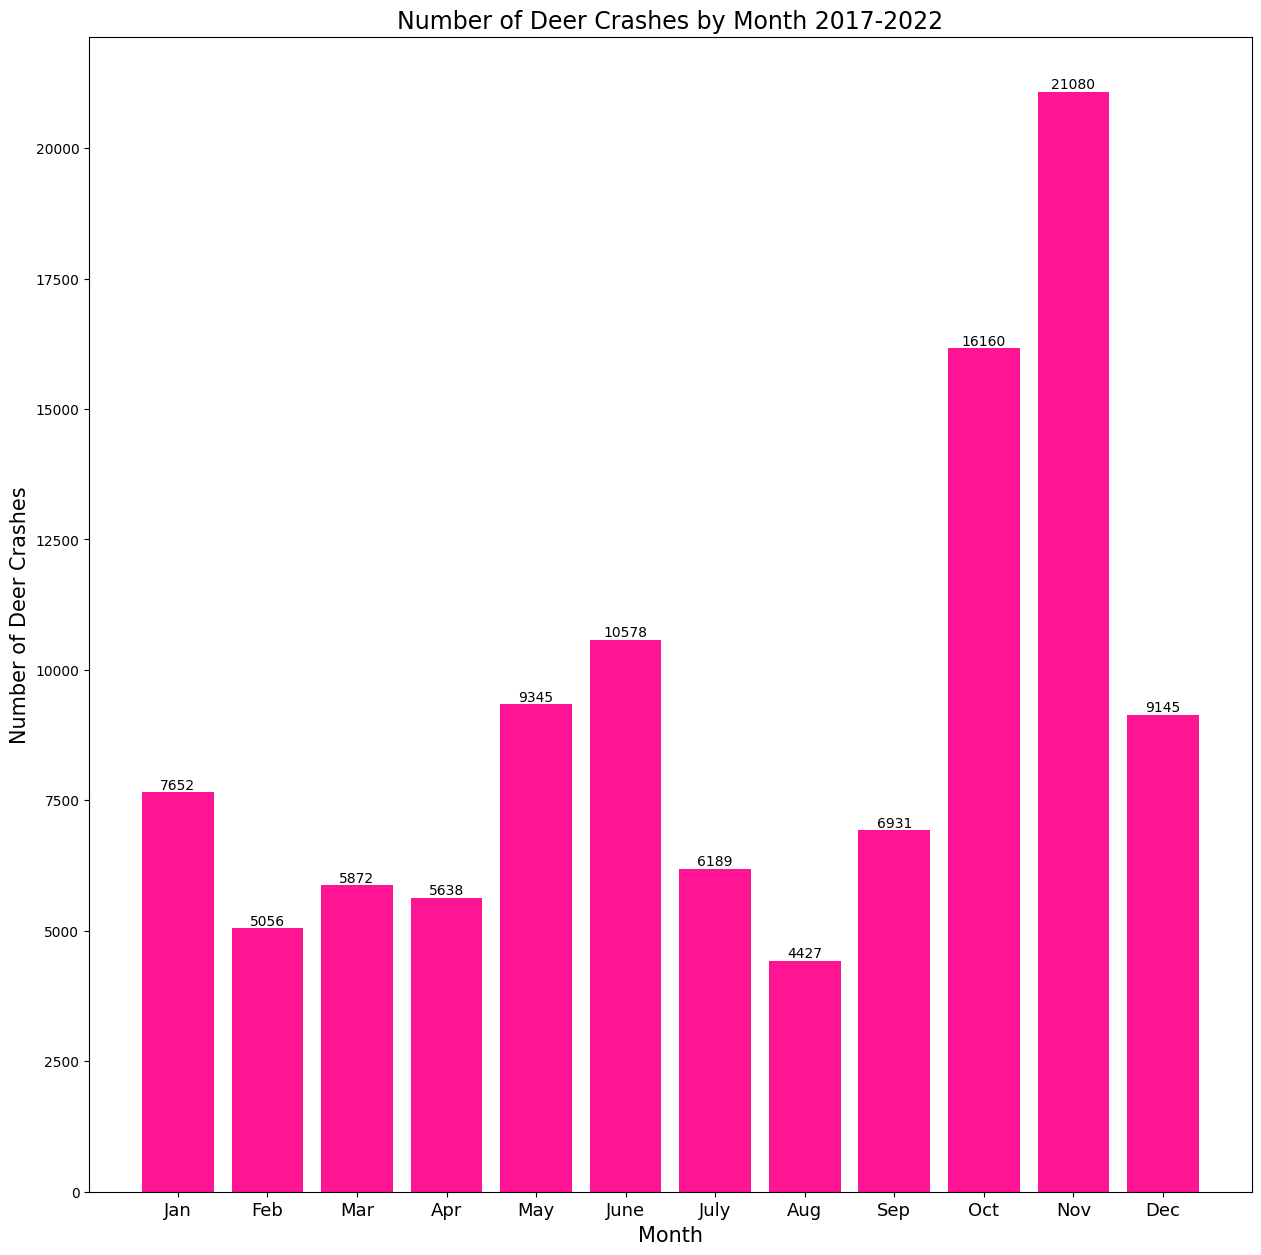

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
y= justdeer2.nummonth.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y, color='deeppink')

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=13)

ax.set_ylabel("Number of Deer Crashes", fontsize=15)
ax.set_xlabel("Month", fontsize=15)
ax.set_title("Number of Deer Crashes by Month 2017-2022", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Number of Deer Crashes by Month 2017-2022.jpg")

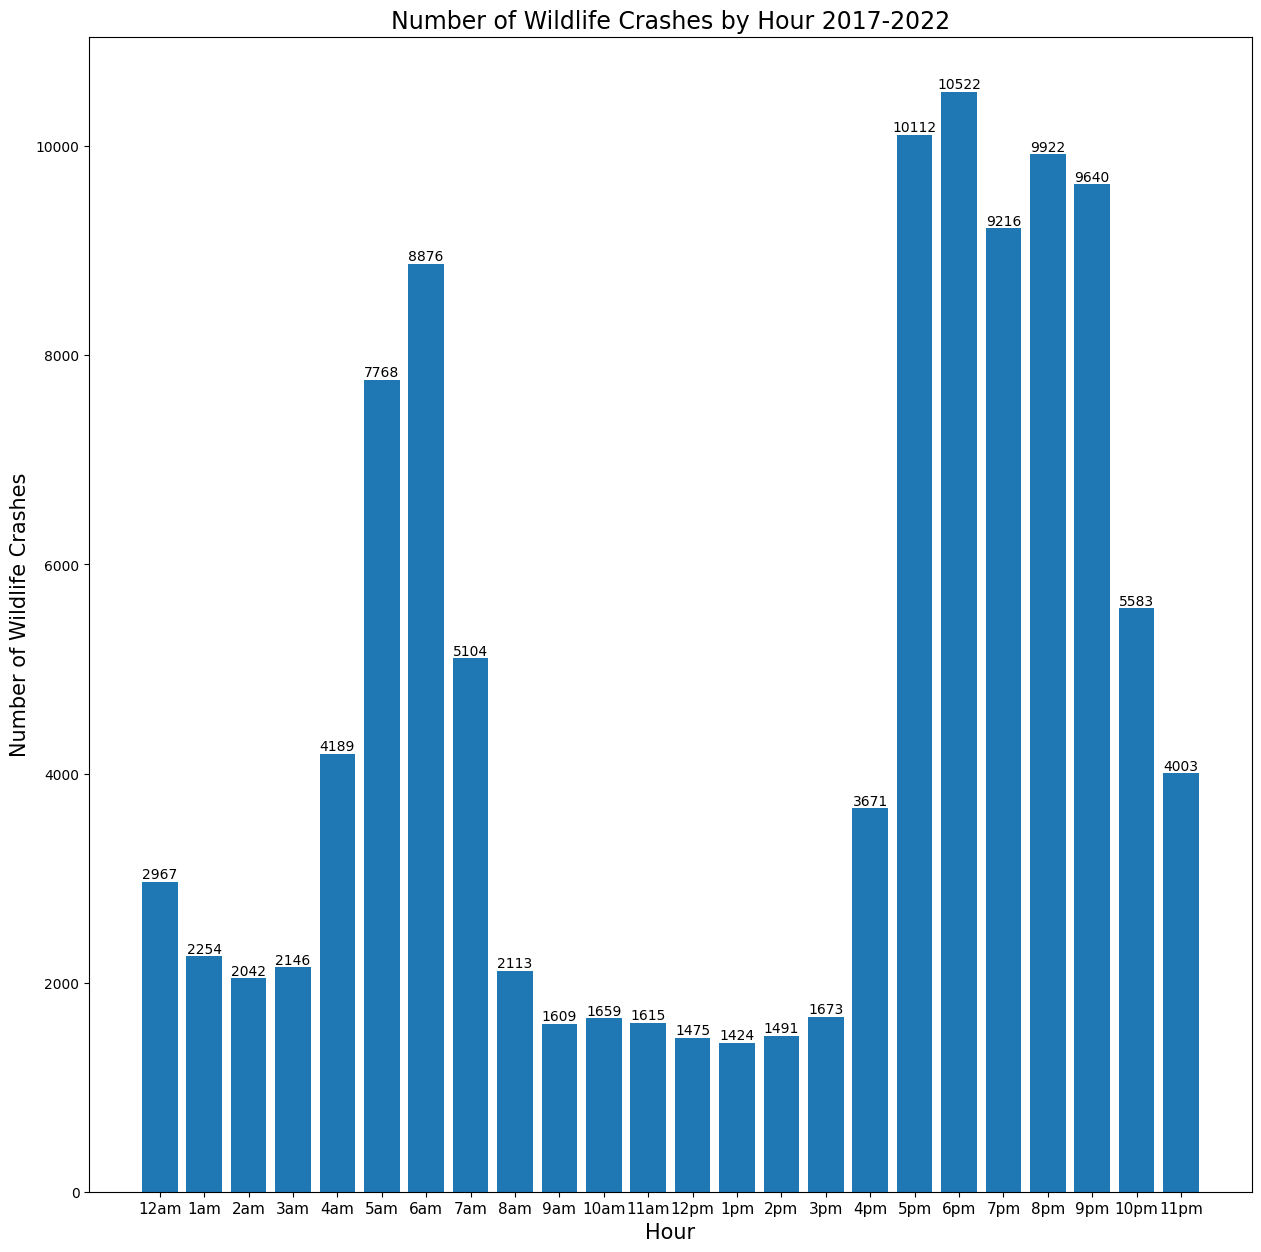

In [26]:
wihour = fullwi.drop(fullwi[fullwi.hour > 23.5].index)
fig, ax = plt.subplots(figsize=(15,15))
y= wihour.hour.value_counts().sort_index()
x= y.index
bar1= ax.bar(x,y)
ax.set_xticks(np.arange(0,24))
ax.set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=11) 
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Hour 2017-2022", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Hour 2017-2022.jpg")

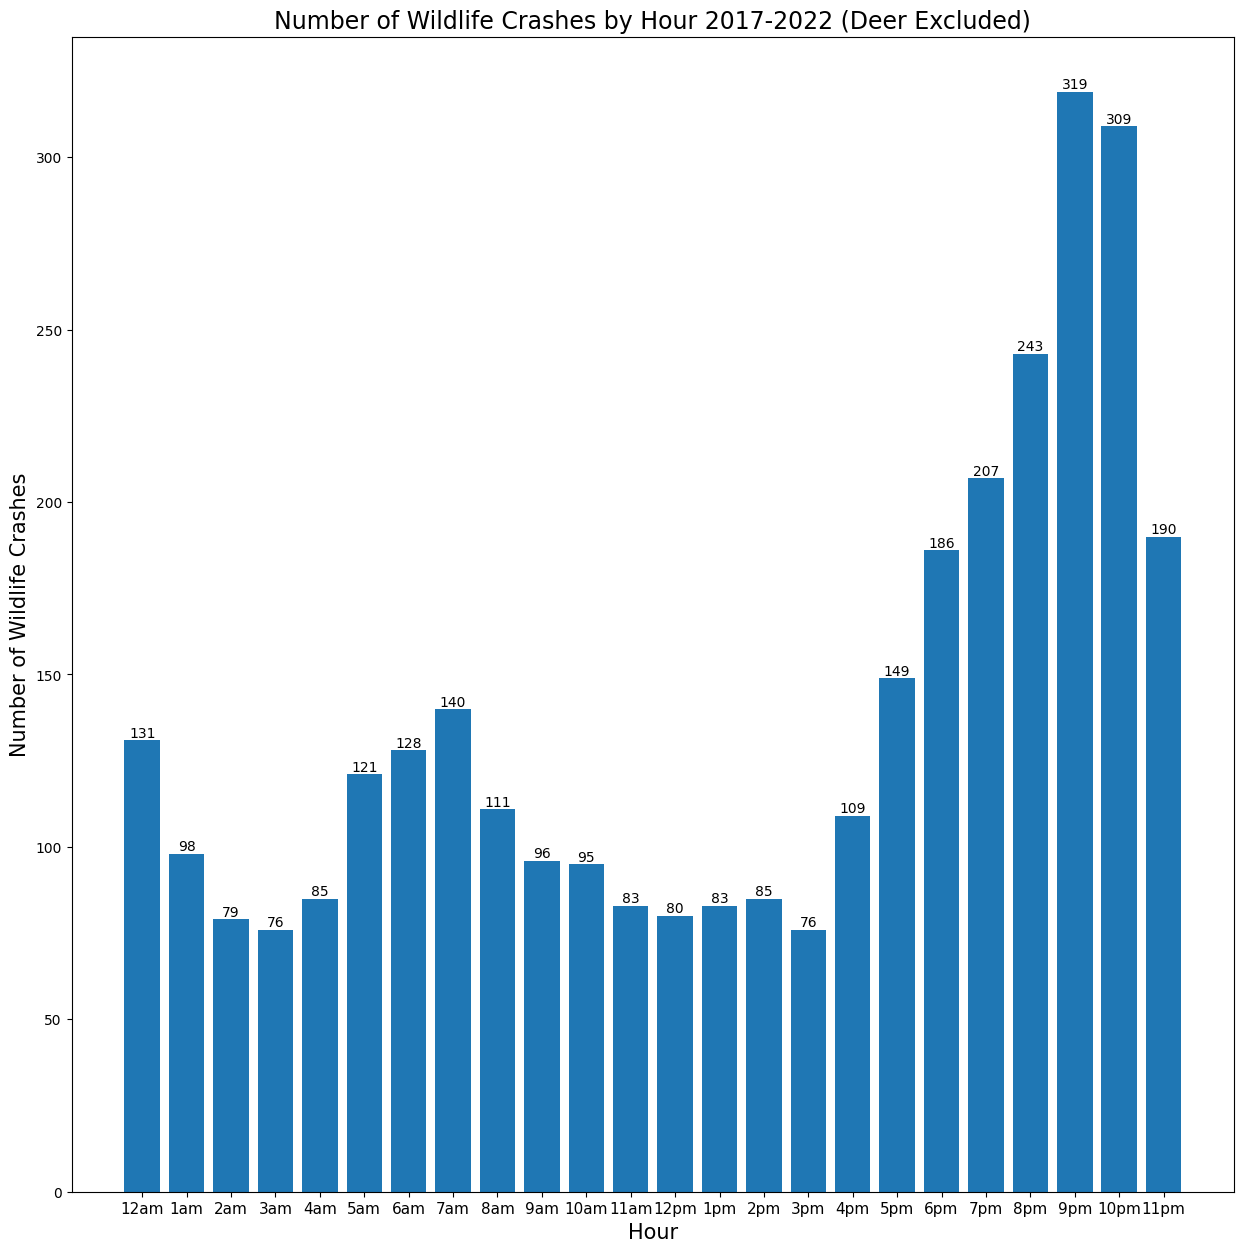

In [27]:
wihournd = wihour.drop(wihour[wihour.ANMLTY01 == "Deer"].index)
fig, ax = plt.subplots(figsize=(15,15))
y= wihournd.hour.value_counts().sort_index()
x= y.index
bar1 = ax.bar(x,y)
ax.set_xticks(np.arange(0,24))
ax.set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=11) 
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Hour 2017-2022 (Deer Excluded)", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Time/Number of Wildlife Crashes by Hour 2017-2022 (Deer Excluded).jpg")

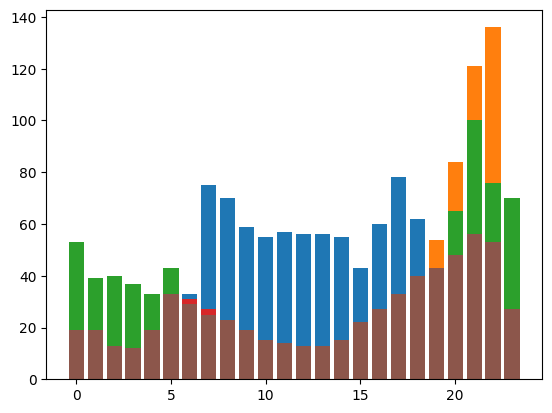

In [21]:
#setup dataframes
wihourtur = wihour.drop(wihour[wihour.ANMLTY01 != "Turkey"].index)
wihourbear = wihour.drop(wihour[wihour.ANMLTY01 != "Bear"].index)
wihourrac = wihour.drop(wihour[wihour.ANMLTY01 != "Raccoon(s)"].index)
wihourcoy = wihour.drop(wihour[wihour.ANMLTY01 != "Coyote"].index)
wihourop = wihour.drop(wihour[wihour.ANMLTY01 != "Opossum"].index)
wihouroth = wihour.drop(wihour[wihour.ANMLTY01 != "Other Non Domesticated"].index)

#setup for the graph
y= wihourtur.hour.value_counts().sort_index()
x= y.index
bar1= plt.bar(x,y)
y= wihourbear.hour.value_counts().sort_index()
x= y.index
bar2= plt.bar(x,y)
y= wihourrac.hour.value_counts().sort_index()
x= y.index
bar3= plt.bar(x,y)
y= wihourcoy.hour.value_counts().sort_index()
x= y.index
bar4= plt.bar(x,y)
y= wihourop.hour.value_counts().sort_index()
x= y.index
bar5= plt.bar(x,y)
y= wihouroth.hour.value_counts().sort_index()
x= y.index
bar6= plt.bar(x,y)

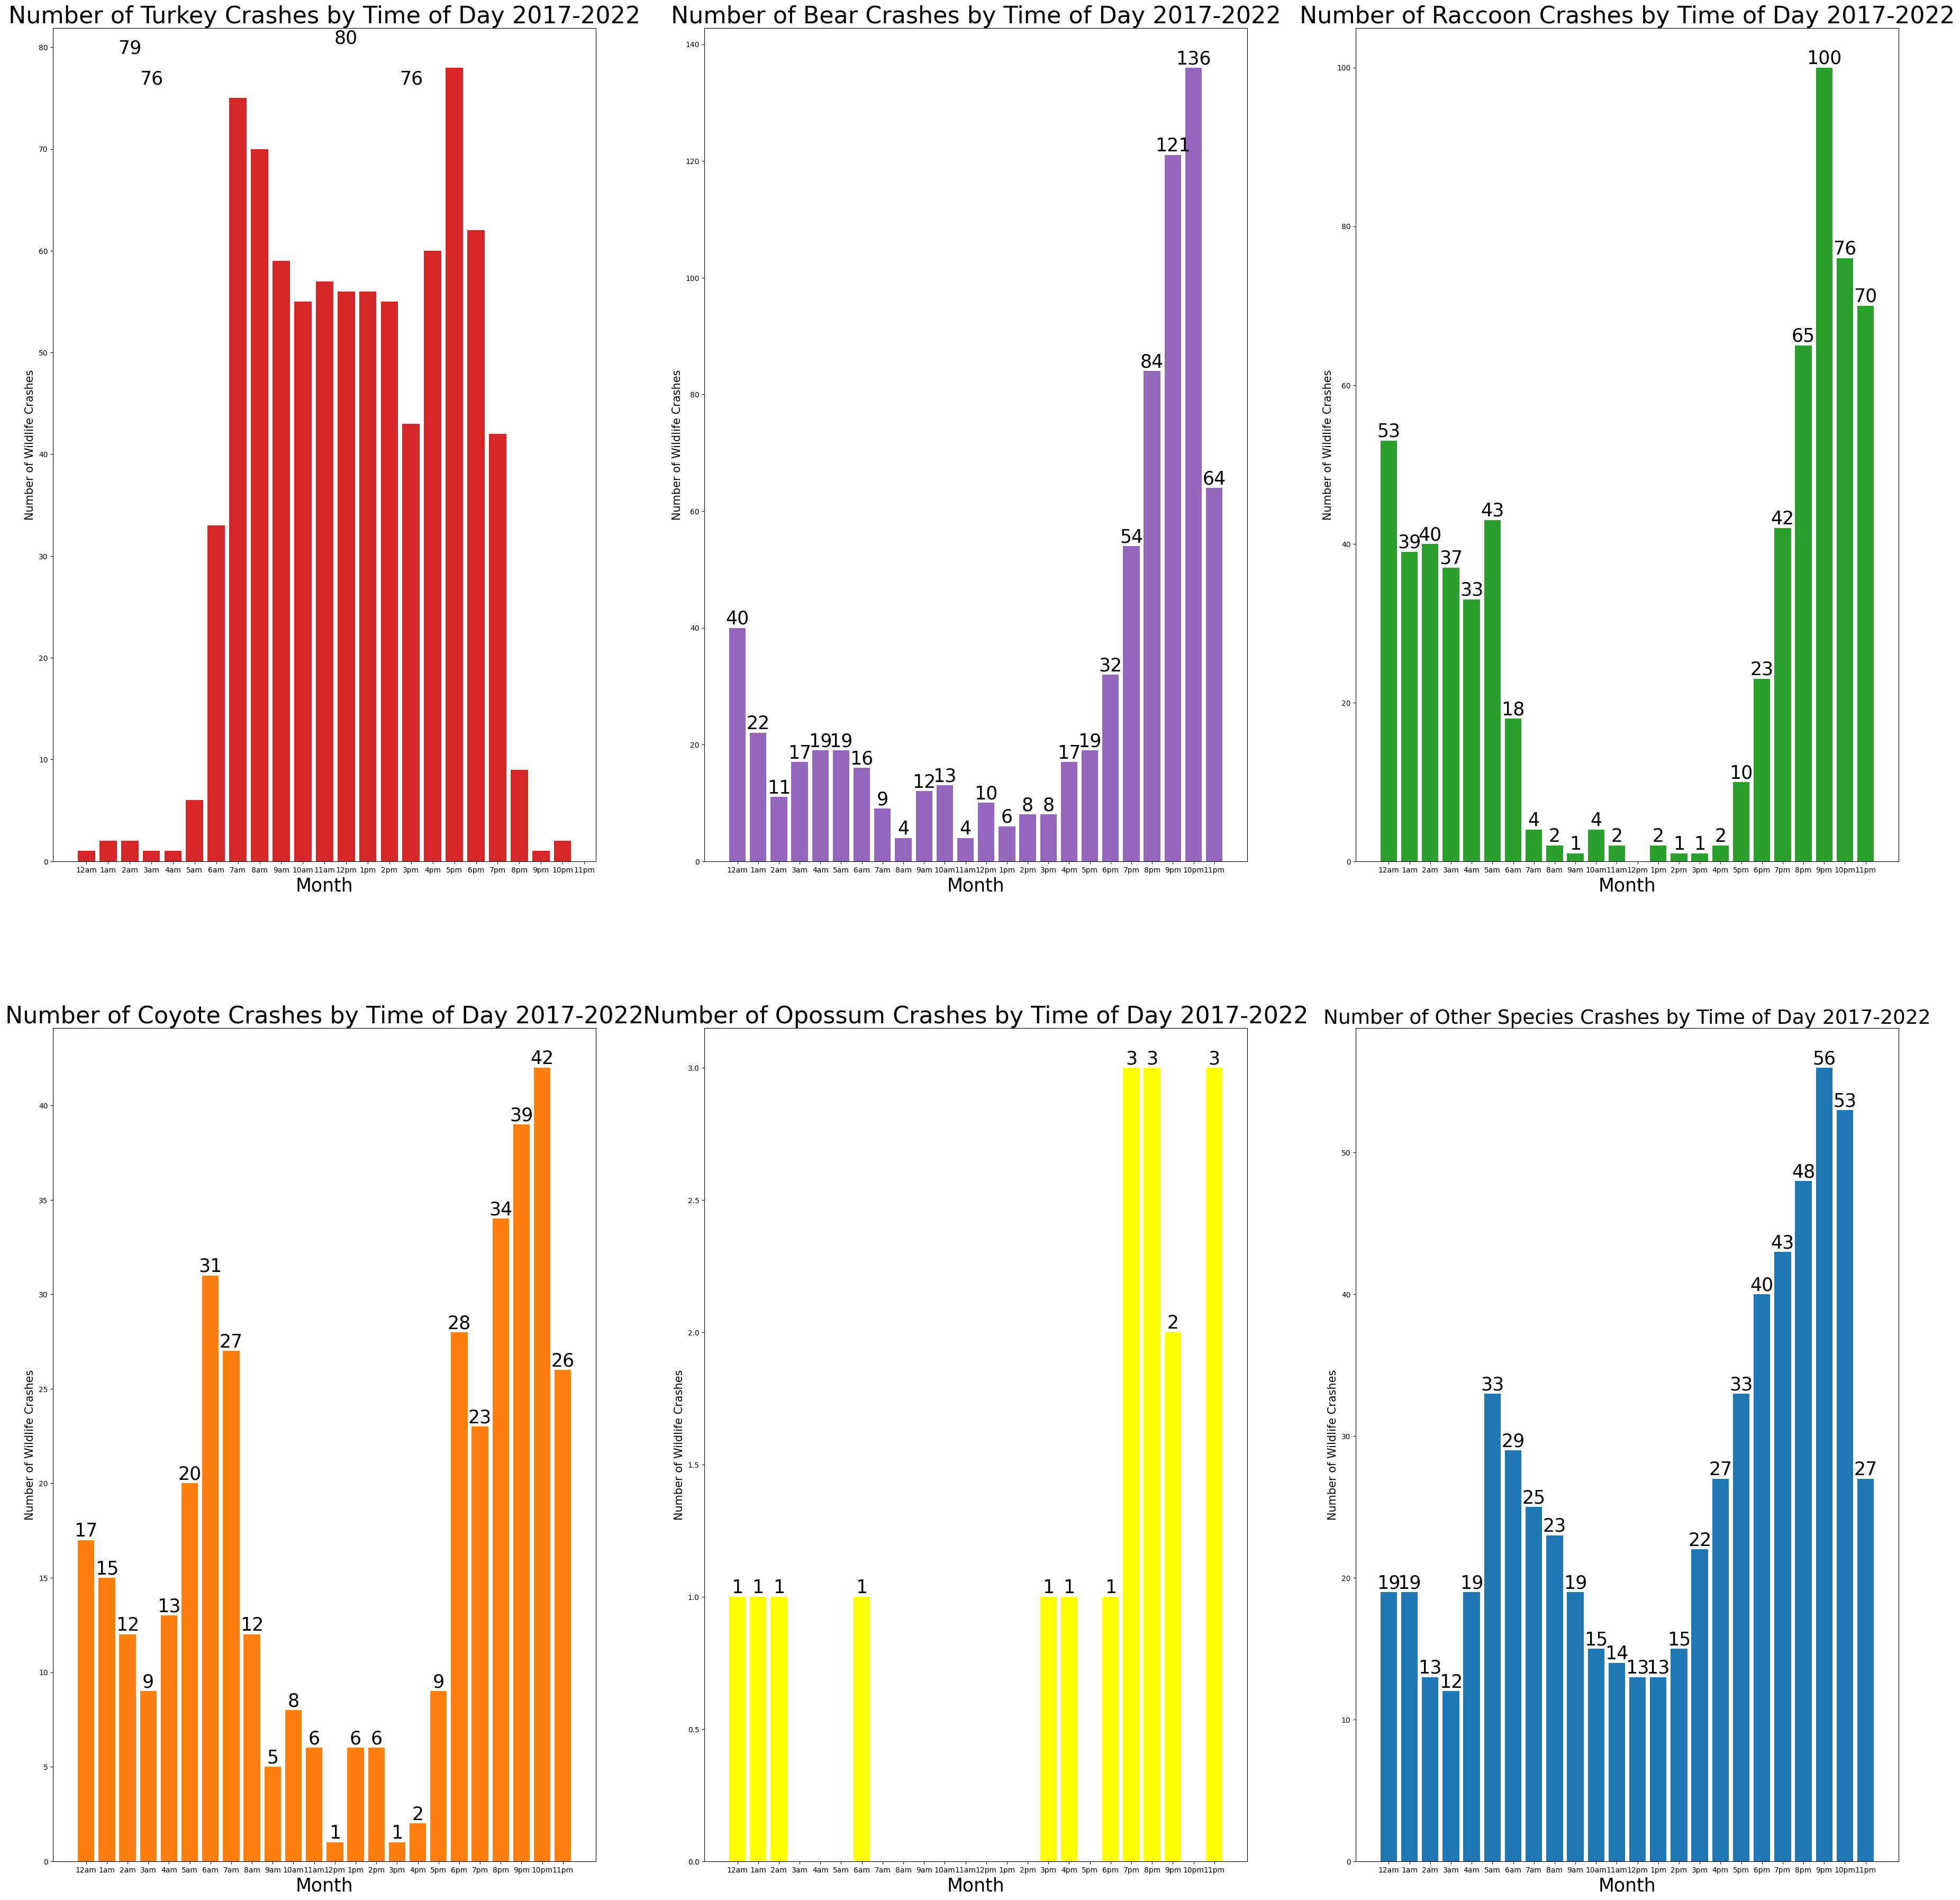

In [28]:
fig, ax = plt.subplots(2,3, figsize=(45,45))
#fig, ax = plt.subplots(figsize=(15,15))
y= wihourtur.hour.value_counts().sort_index()
x= y.index
ax[0,0].bar(x,y, color='tab:red')
ax[0,0].set_xticks(np.arange(0,24))
ax[0,0].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10) 
ax[0,0].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,0].set_xlabel("Month", fontsize=25)
ax[0,0].set_title("Number of Turkey Crashes by Time of Day 2017-2022", fontsize=32)
ax[0,0].bar_label(bar1, fontsize=25)
###
y= wihourbear.hour.value_counts().sort_index()
x= y.index
ax[0,1].bar(x,y, color='tab:purple')
ax[0,1].set_xticks(np.arange(0,24))
ax[0,1].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10) 
ax[0,1].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,1].set_xlabel("Month", fontsize=25)
ax[0,1].set_title("Number of Bear Crashes by Time of Day 2017-2022", fontsize=32)
ax[0,1].bar_label(bar2, fontsize=25)
###
y= wihourrac.hour.value_counts().sort_index()
x= y.index
ax[0,2].bar(x,y, color='tab:green')
ax[0,2].set_xticks(np.arange(0,24))
ax[0,2].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10)
ax[0,2].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[0,2].set_xlabel("Month", fontsize=25)
ax[0,2].set_title("Number of Raccoon Crashes by Time of Day 2017-2022", fontsize=32)
ax[0,2].bar_label(bar3, fontsize=25)
###
y= wihourcoy.hour.value_counts().sort_index()
x= y.index
ax[1,0].bar(x,y, color='tab:orange')
ax[1,0].set_xticks(np.arange(0,24))
ax[1,0].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10) 
ax[1,0].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,0].set_xlabel("Month", fontsize=25)
ax[1,0].set_title("Number of Coyote Crashes by Time of Day 2017-2022", fontsize=32)
ax[1,0].bar_label(bar4, fontsize=25)
###
y= wihourop.hour.value_counts().sort_index()
x= y.index
ax[1,1].bar(x,y, color='yellow')
ax[1,1].set_xticks(np.arange(0,24))
ax[1,1].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10) 
ax[1,1].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,1].set_xlabel("Month", fontsize=25)
ax[1,1].set_title("Number of Opossum Crashes by Time of Day 2017-2022", fontsize=32)
ax[1,1].bar_label(bar5, fontsize=25)
###
y= y= wihouroth.hour.value_counts().sort_index()
x= y.index
ax[1,2].bar(x,y, color='tab:blue')
ax[1,2].set_xticks(np.arange(0,24))
ax[1,2].set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=10) 
ax[1,2].set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax[1,2].set_xlabel("Month", fontsize=25)
ax[1,2].set_title("Number of Other Species Crashes by Time of Day 2017-2022", fontsize=27)
ax[1,2].bar_label(bar6, fontsize=25)
plt.savefig("Figures/Bar Graphs/Time/Number of Multi Species Crashes by Time of Day 2017-2022.jpg")
#I recommend opening the .jpg or opening the image in a new tab to see it more clearly

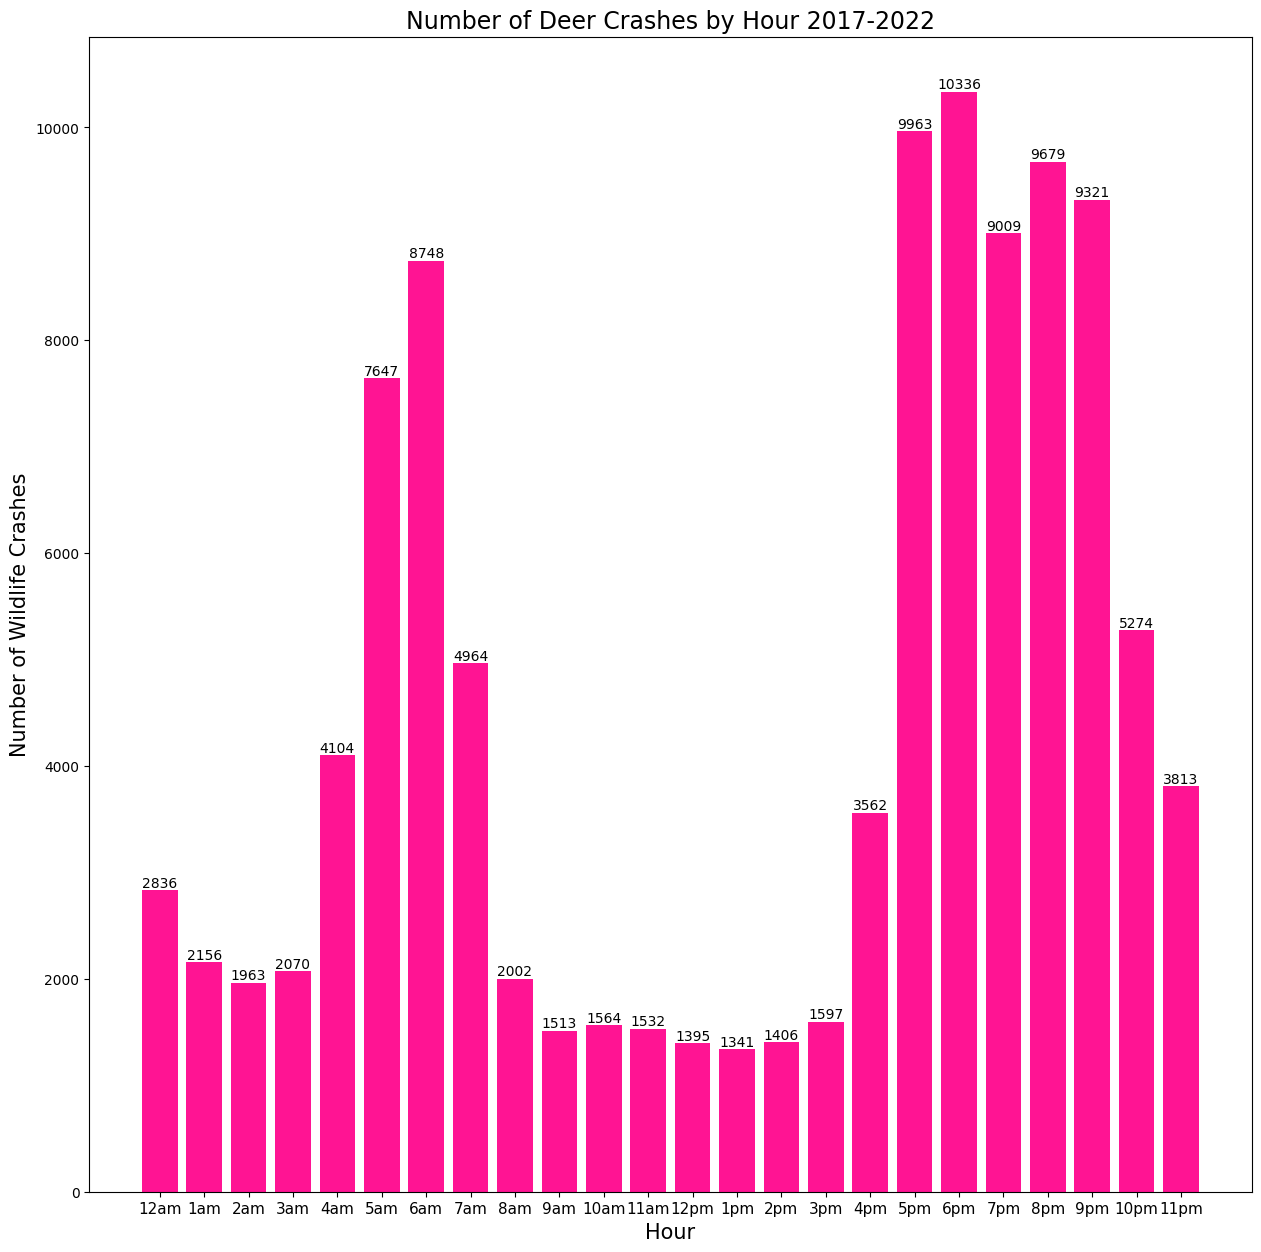

In [29]:
wihourde = wihour.drop(wihour[wihour.ANMLTY01 != "Deer"].index)
fig, ax = plt.subplots(figsize=(15,15))
y= wihourde.hour.value_counts().sort_index()
x= y.index
bar1 = ax.bar(x,y, color='deeppink')
ax.set_xticks(np.arange(0,24))
ax.set_xticklabels(["12am","1am","2am","3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
                   "12pm","1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm"], fontsize=11) 
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_title("Number of Deer Crashes by Hour 2017-2022", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Time/Number of Deer Crashes by Hour 2017-2022.jpg")

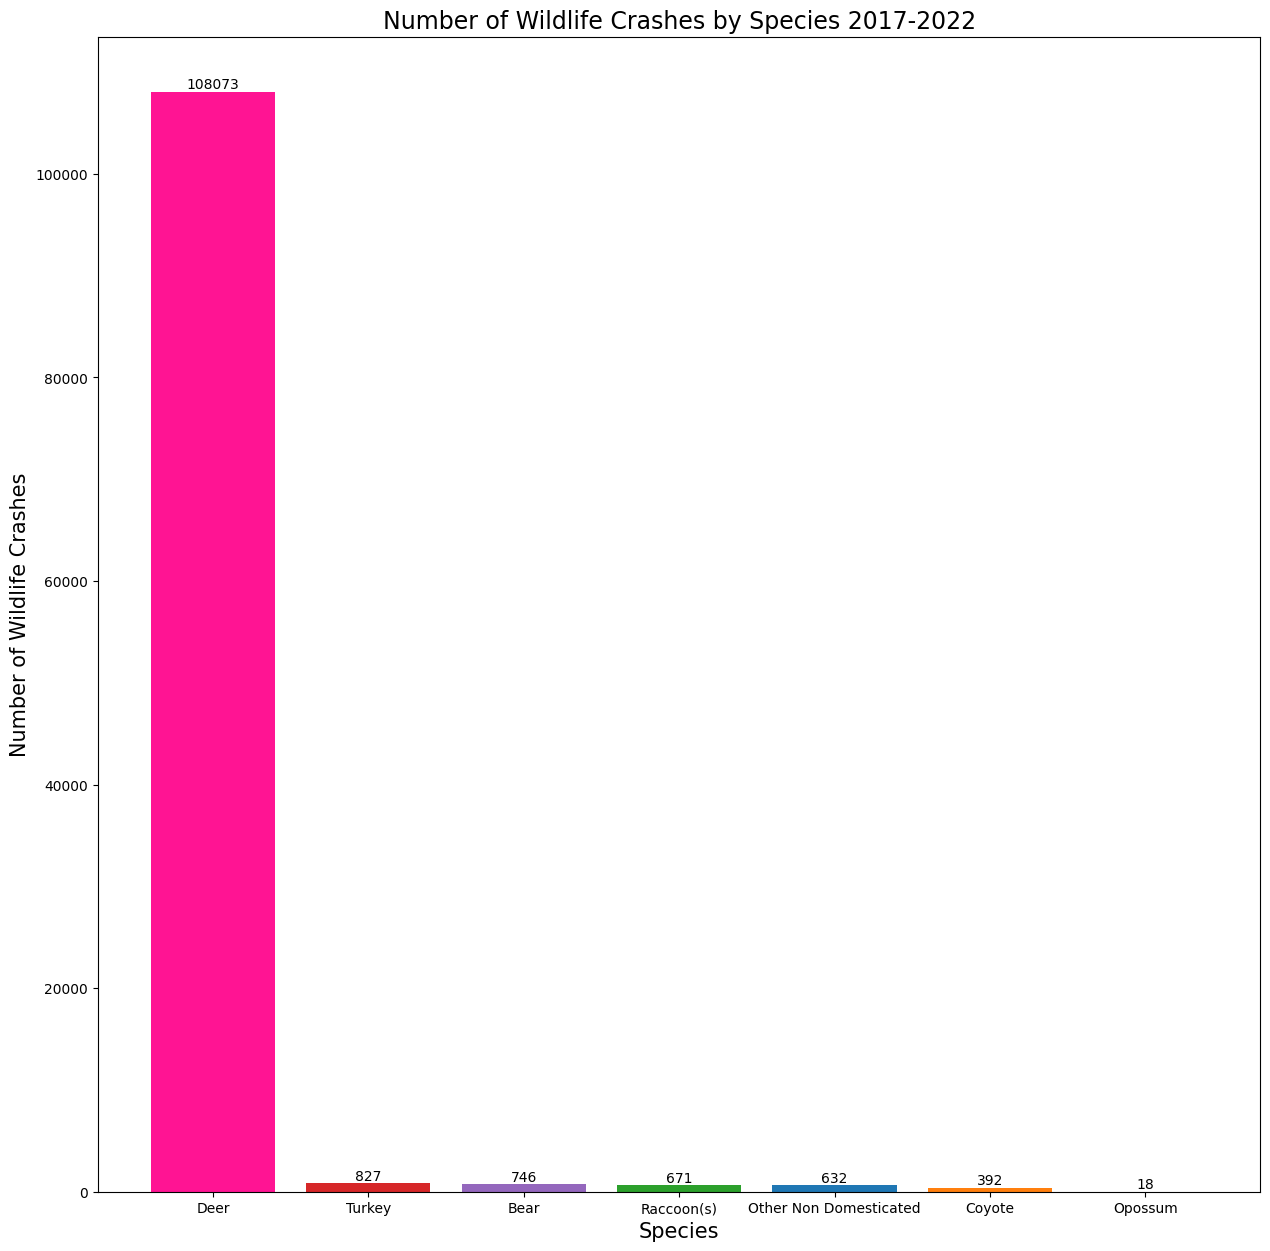

In [32]:
fig, ax =plt.subplots(figsize=(15,15))
y= fullwi.ANMLTY01.value_counts()
x= y.index
bar1= ax.bar(x,y, color=['deeppink','tab:red','tab:purple','tab:green','tab:blue','tab:orange','yellow'])
 
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Species", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Species 2017-2022", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Species/Species Crashes 2017-2022.jpg")

NameError: name 'quicknd' is not defined

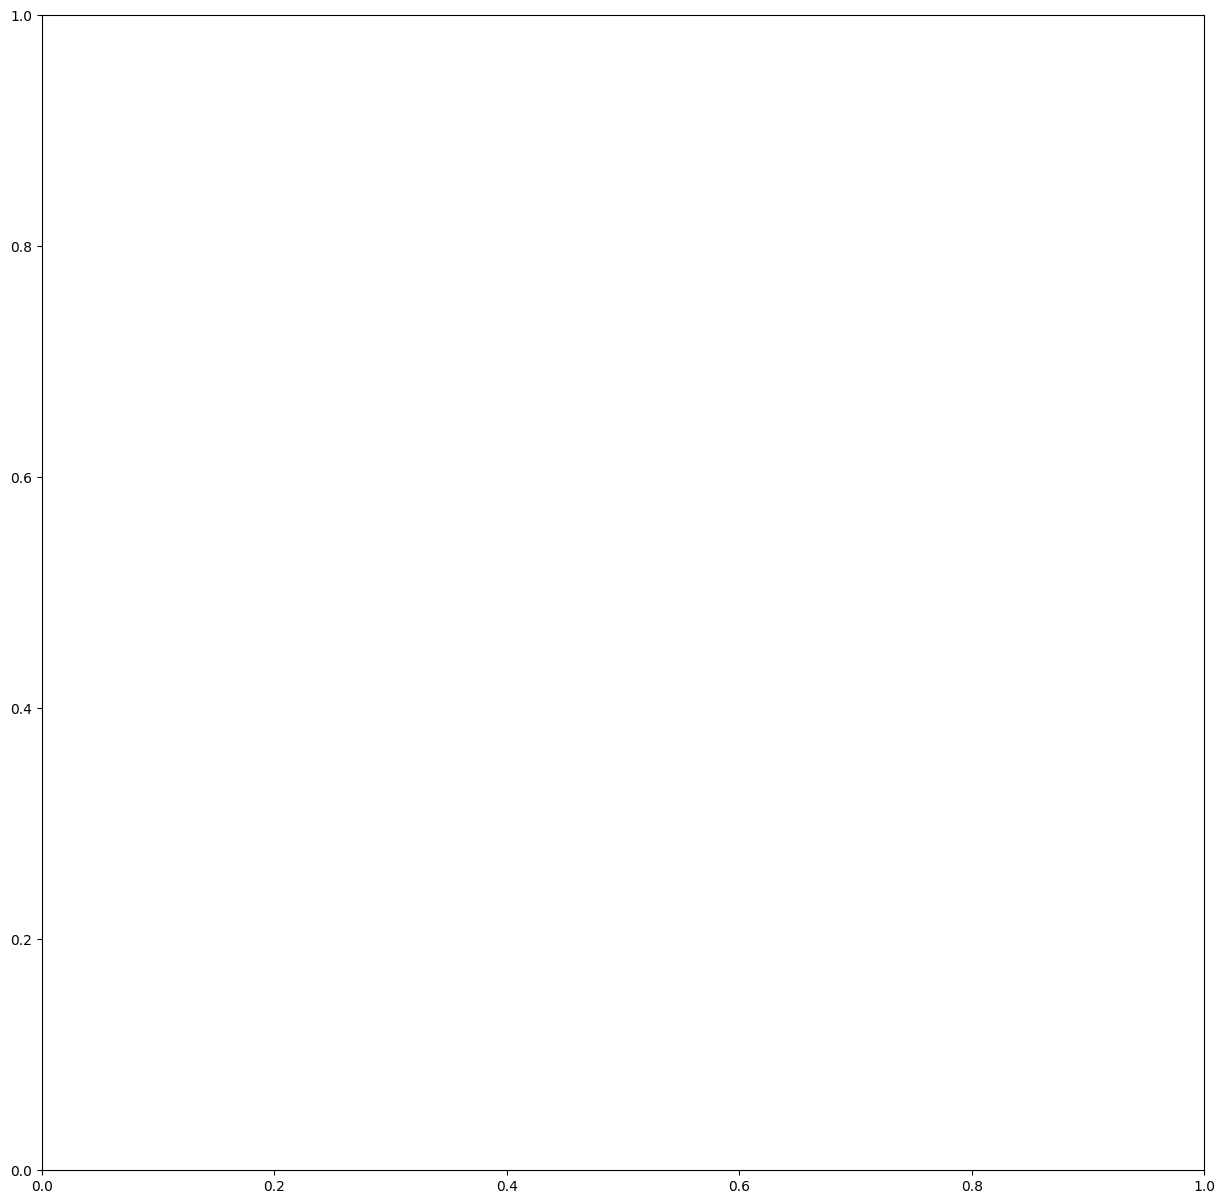

In [33]:
fig, ax =plt.subplots(figsize=(15,15))
y= quicknd.ANMLTY01.value_counts()
x= y.index
bar1= ax.bar(x,y, color=['tab:red','tab:purple','tab:green','tab:blue','tab:orange','yellow'])
 
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Species", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Species 2017-2022 (Deer Excluded)", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Species/Species Crashes (Deer Excluded) 2017-2022.jpg")

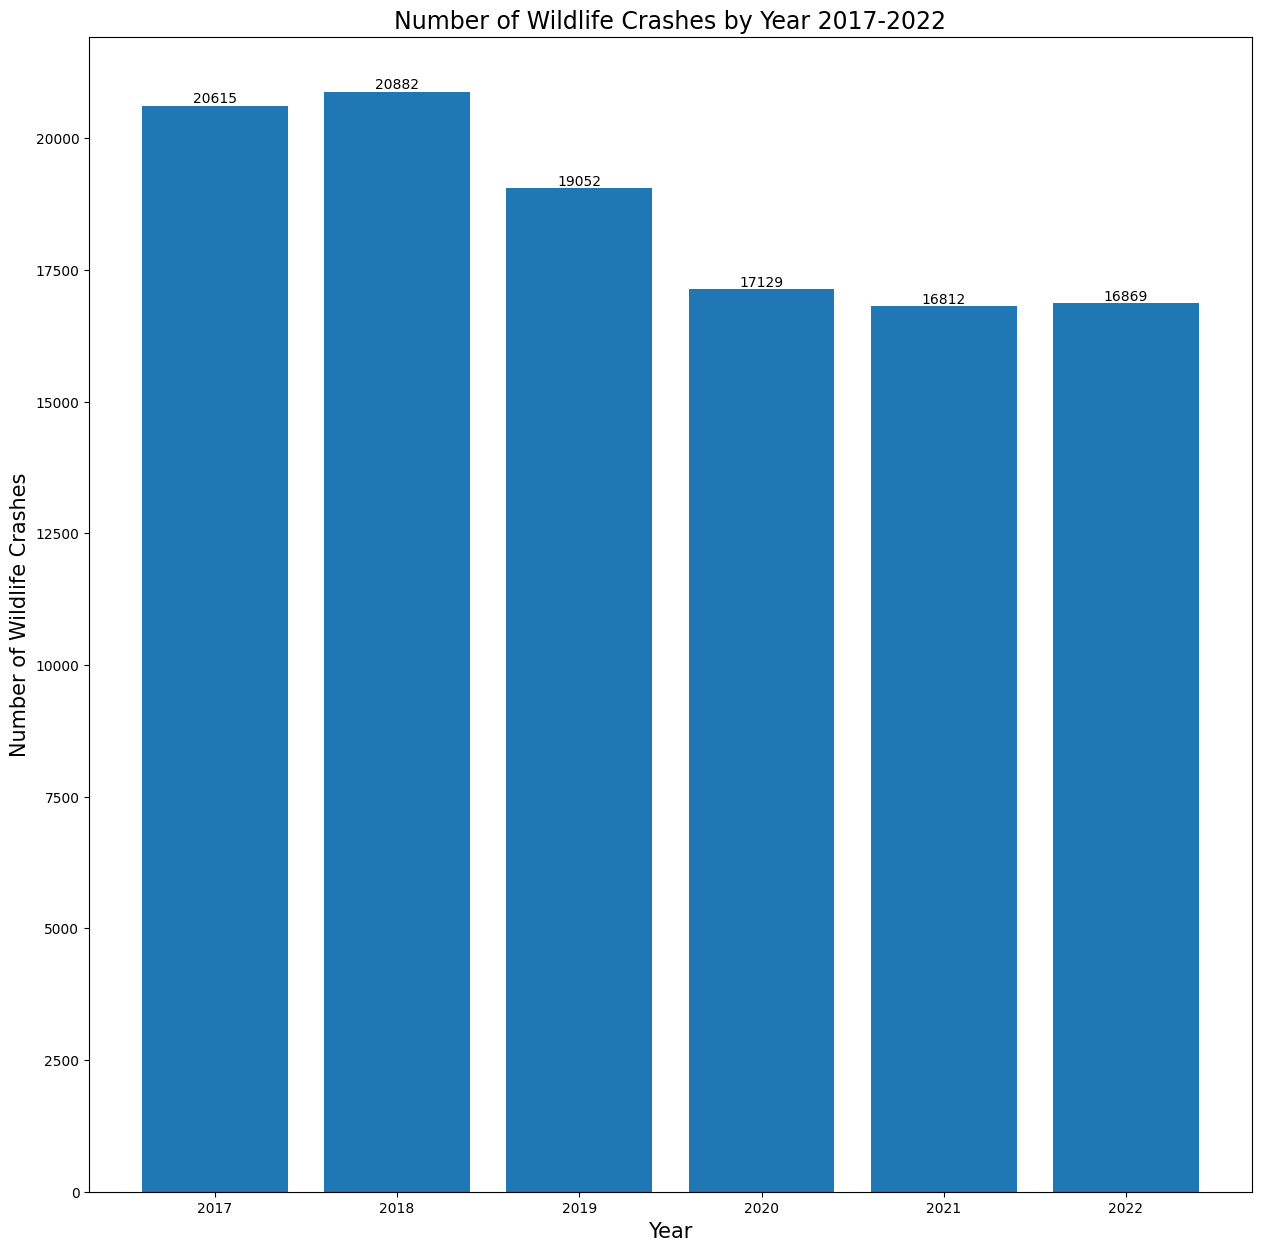

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
y= fullwi.year.value_counts().sort_index()
x= y.index
bar1 = ax.bar(x,y)
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Year 2017-2022", fontsize=17)
ax.bar_label(bar1)
plt.savefig("Figures/Bar Graphs/Time/Species Crashes by year 2017-2022.jpg")

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
y= quicknd.year.value_counts().sort_index()
x= y.index
bar1 = ax.bar(x,y)
ax.set_ylabel("Number of Wildlife Crashes", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.set_title("Number of Wildlife Crashes by Year 2017-2022 (Deer excluded)", fontsize=17)
ax.bar_label(bar1)
#plt.savefig("Figures/Bar Graphs/Time/Species Crashes by year (Deer excluded) 2017-2022.jpg")

NameError: name 'quickroadtest' is not defined

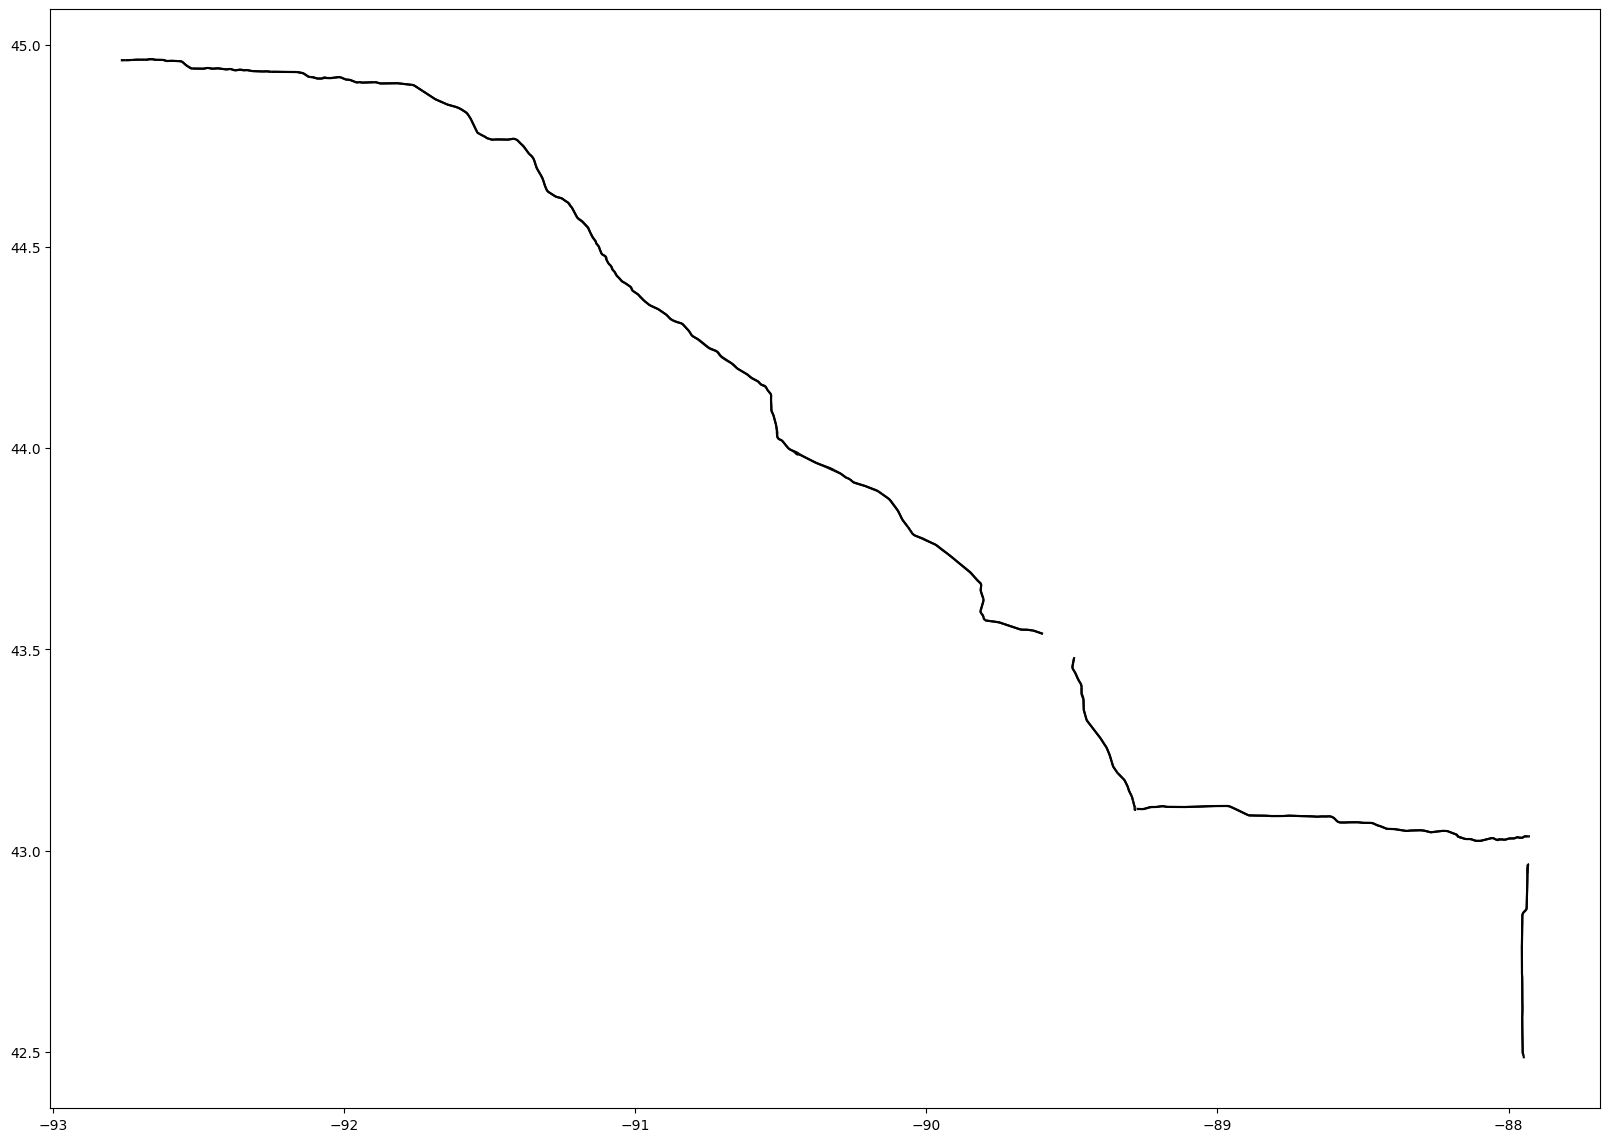

In [31]:
fig, ax = plt.subplots(figsize=(20,20))
#BareWi.plot(ax=ax, color="lightgray")
i94.plot(ax=ax, color="black", zorder=1, alpha=1)
p = sns.kdeplot(ax = ax,
                data = quickroadtest,
                x = "LONDECDG",
                y = "LATDECDG",
                #linewidth = .5,
                fill=True,
                cmap='CMRmap',
                levels=20,
                cbar=True,
                #legend=True,
                alpha = .7)


ax.set_xlabel("Longitude",fontsize=23)
ax.set_ylabel("Latitude", fontsize=23)
ax.grid(b=True, alpha=0.3)
plt.xticks(np.arange(-93, -87, .5), fontsize=15)
plt.yticks(np.arange(42, 45.5, .5), fontsize=15)
ax.set_title("Wildlife Crash Reports in Wisconsin Heatmap 2017-2022 (Deer excluded)", fontsize=20)
plt.savefig("Figures/Wildlife Crash Reports 2017-2022 Wisconsin Heatmap no Deer.jpg")

In [ ]:
quicknd = fullwi.drop(fullwi[fullwi.ANMLTY01 == "Deer"].index)
justdane= fullwi.drop(fullwi[fullwi.countyname != "Dane"].index)
qnddane = justdane.drop(justdane[justdane.ANMLTY01 == "Deer"].index)

In [ ]:
justrac = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Raccoon(s)"].index)
justop = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Opossum"].index)
justcoy = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Coyote"].index)
justtur = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Turkey"].index)
justbear = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Bear"].index)
justnon = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Other Non Domesticated"].index)
justdeer2 = fullwi.drop(fullwi[fullwi.ANMLTY01 != "Deer"].index)

In [43]:
wiinfo

Name     Pop  Area  Counts
0       Adams   20588   646     NaN
1     Ashland   15988  1045     NaN
2      Barron   46963   863     NaN
3    Bayfield   16583  1478     NaN
4       Brown  274959   530     NaN
..        ...     ...   ...     ...
67   Waukesha  412105   550     NaN
68    Waupaca   51632   748     NaN
69   Waushara   24526   626     NaN
70  Winnebago  173152   434     NaN
71       Wood   74045   793     NaN

[72 rows x 4 columns]

In [65]:
wiinfo["Counts"]=atest["Counts"]
wiinfo

Name     Pop  Area  Counts
0       Adams   20588   646     695
1     Ashland   15988  1045     594
2      Barron   46963   863     270
3    Bayfield   16583  1478     809
4       Brown  274959   530    2694
..        ...     ...   ...     ...
67   Waukesha  412105   550    5276
68    Waupaca   51632   748    1871
69   Waushara   24526   626     991
70  Winnebago  173152   434    2674
71       Wood   74045   793     819

[72 rows x 4 columns]

In [64]:
wiinfo= pd.read_csv("wiinfo.csv")
wiinfo

Name     Pop  Area
0       Adams   20588   646
1     Ashland   15988  1045
2      Barron   46963   863
3    Bayfield   16583  1478
4       Brown  274959   530
..        ...     ...   ...
67   Waukesha  412105   550
68    Waupaca   51632   748
69   Waushara   24526   626
70  Winnebago  173152   434
71       Wood   74045   793

[72 rows x 3 columns]

In [44]:
ccctest.dtype

dtype('int64')

In [63]:
atest=aatest.reset_index()
atest=atest.drop("index", axis=1)
atest

Name  Counts
0       Adams     695
1     Ashland     594
2      Barron     270
3    Bayfield     809
4       Brown    2694
..        ...     ...
67   Waukesha    5276
68    Waupaca    1871
69   Waushara     991
70  Winnebago    2674
71       Wood     819

[72 rows x 2 columns]

In [59]:
aaatest=ccctest.reset_index()
aaatest = aaatest.rename(columns={'index': 'Name', 'countyname': 'Counts'})
aatest= aaatest.sort_values('Name')
aatest
#df = df.reset_index() 

Name  Counts
51      Adams     695
54    Ashland     594
65     Barron     270
47   Bayfield     809
10      Brown    2694
..        ...     ...
1    Waukesha    5276
22    Waupaca    1871
37   Waushara     991
12  Winnebago    2674
46       Wood     819

[72 rows x 2 columns]

In [57]:
ccctest=fullwi["countyname"].value_counts()
ccctest

Dane          5395
Waukesha      5276
Washington    4847
Sheboygan     4400
Manitowoc     4045
              ... 
Pepin          163
Florence       155
Iron           141
Pierce         129
Menominee       36
Name: countyname, Length: 72, dtype: int64

In [14]:
wicord.year.value_counts()


2018    20475
2017    19704
2019    18950
2020    17012
2022    16834
2021    16738
Name: year, dtype: int64